In [1]:
import pandas as pd
# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib.colors import hex2color, rgb2hex,LinearSegmentedColormap, ListedColormap
import seaborn as sns
import datetime
import json
import numpy as np
from scipy import stats
import networkx as nx
import os
#from causalimpact import CausalImpact
#from sklearn.preprocessing import normalize

In [2]:
# Main color for the plot
main_color_hex = '#1b1c3a'
main_color = hex2color(main_color_hex)
second_color_hex = '#ffcc03'
second_color = hex2color(second_color_hex)

colors = [main_color, 'black', 'white', second_color] # first color is black, last is red
edmo_divert = LinearSegmentedColormap.from_list(
        "EDMO_divert", colors, N=40)
edmo_cat = ListedColormap(edmo_divert(np.linspace(0, 1, 15)), N=20)
edmo_cat.name = 'EDMO_cat'
mpl.colormaps.register(edmo_divert)
mpl.colormaps.register(edmo_cat)

sns_color_palette_cat = sns.color_palette('tab20')
#sns_color_palette_cat = sns.color_palette('EDMO_divert')
sns.set_style("white")
# Size of the figure to match the latex document

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "figure.figsize" : (4.5, 4),
    "font.size":    11.0,
    'legend.fontsize' : 8,
    'xtick.labelsize' : 9,
    'ytick.labelsize' : 9

})


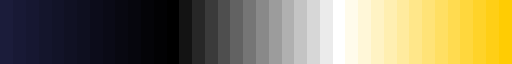

In [3]:
edmo_divert

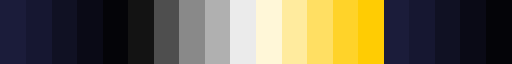

In [4]:
edmo_cat

In [5]:
sns.color_palette('tab20')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [6]:
# Mkdir folder for plots if not existing
folder_plots_eps = './plots/eps/'
os.makedirs(folder_plots_eps, exist_ok=True)
folder_plots_png = './plots/png/'
os.makedirs(folder_plots_png, exist_ok=True)

sample_folders = ['all', 'eval', 'topic_relation', 'on_topic']

for sample_folder in sample_folders:
    eps_path = os.path.join(folder_plots_eps, sample_folder)
    png_path = os.path.join(folder_plots_png, sample_folder)
    os.makedirs(eps_path, exist_ok=True)
    os.makedirs(png_path, exist_ok=True)

### Functions

In [7]:
def extract_value_from_dict(df, colname, val_pos):
    df_temp = pd.json_normalize(df[colname])
    df_temp = df_temp.applymap(lambda x: list(x.values())[val_pos] if isinstance(x, dict) else x)
    df_temp.columns = [f"{colname}_{x}" for x in df_temp.columns]
    df = df.drop(colname, axis=1)
    return pd.concat([df, df_temp], axis=1)

In [8]:
def extract_values(series, key):
    def extract(row):
        values = []
        for d in row:
            if key in d:
                values.append(d[key])
        return values
    return series.apply(extract)

In [9]:
def define_colours(df, column):
    # Define the colour for the fact-checker to be coherent
    colours_fact_checker = dict()
    df = df.explode(column)

    for i, j in enumerate(np.sort(df[column].unique())):
        colours_fact_checker[j] = plt.cm.colors.to_rgba(sns_color_palette_cat[i])
    return colours_fact_checker


def get_values_count(df, column):
    df = df.explode(column)
    df_counts = df[column].value_counts(normalize=False).to_frame().reset_index().set_axis([column, 'Counts'],  axis=1)
    df_counts['Percentages'] = df[column].value_counts(normalize=True).values*100
    df_counts['Percentages'] = df_counts['Percentages'].apply(lambda x: round(x, 1))
    return df_counts


def output_df_for_cross(df, field1, field2, reorder_first=True, reorder_second=True):
    # Generate the groupby df 
    df = df.explode(field1)
    df = df.explode(field2)
    # Count the value and create a table
    df = df.groupby([field1, field2]).size().unstack(fill_value=0)
    # Reorder per first category
    if reorder_first is True:
        df = df.assign(tmp=df.sum(axis=1)).sort_values('tmp', ascending=True).drop(labels='tmp', axis=1)
    # Reorder for the second category
    if reorder_second is True:
        df = df.transpose().assign(tmp=df.sum(axis=0)).sort_values('tmp', ascending=False).drop(labels='tmp', axis=1).transpose()
    # Normalised
    df_norm = df.div(df.sum(axis=1), axis=0)

    return df, df_norm

In [10]:
def plot_counts(df, column, color=main_color, kind_bar='bar', width_bar=0.9): 
                
    fig, ax = plt.subplots()
    sns.despine(offset=5, trim=False);
    #fig.suptitle(f"Number of fact-checks published on the Iberifier API [{min(df_iberifier['date'])} - {max(df_iberifier['date'])}]")
    
    # In case of horizontal plot, reorder to avoid having the highest count at the bottom
    if kind_bar == 'barh':
        df = df.sort_values(by='Counts', ascending=True)
        
    df.plot(kind=kind_bar, x=column, y='Counts', stacked=True,ax=ax, legend=None, width=width_bar, color=color)
  
    ax.set(xlabel= column)
    ax.set(ylabel='Count')
    ax.tick_params(rotation=0)

    #plt.tight_layout()
    filename = f'claims_{column}'
    save_plot(fig, ax, filename, sample, legend=None)


    #plt.show()
    return plt



def plot_cross(df, field1, field2, colours, legend_position=None, width_bar=1, norm=False):

    fig, ax = plt.subplots(figsize=(5, 7))
    
    if norm:
        sns.despine(offset=None, trim=False, left=True, bottom=True)
        filename = f"{field1}_{field2}_norm"

    else:
        sns.despine(offset=5, trim=False);
        filename = f"{field1}_{field2}"


    #fig.suptitle(f"{field1} and {field2} of claims [{min(df_iberifier['date'])} - {max(df_iberifier['date'])}]")

    df.plot.barh(stacked=True, ax=ax, color= color_palette, width=width_bar, linewidth=0.3)
    ax.set(xlabel='Count')
    ax.set(ylabel=f'{field1}')

    ax.tick_params(rotation=0)


    save_plot(fig, ax, filename, sample, legend_position=legend_position)

    return plt

def plot_per_day(df, column, colours, legend_position=None, width_bar=0.9):
    
    fig, ax = plt.subplots()
    sns.despine(offset=5, trim=False);
    #fig.suptitle(f"Number of fact-checks published on the Iberifier API [{min(df_iberifier['date'])} - {max(df_iberifier['date'])}]")
    
    df.plot(kind='bar', ax=ax, stacked=True, color=colours, width=width_bar) 
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.set(xlabel='Dates')
    ax.set(ylabel='Count')

    ax.tick_params(rotation=90)


    #plt.tight_layout()

    filename = f'claims_{column}'
    save_plot(fig, ax, filename, sample, legend_position=legend_position)

    


    
    #plt.show()
    return plt

def save_plot(fig, ax, filename, sample, half_sise=False, png_size=None, eps_size=None, legend=None, legend_position=None):
    
    def despine(ax, color):
        try:
            for spine in ax.spines.values():
                spine.set_edgecolor(color)
            ax.tick_params(axis='both', colors=color)
            ax.xaxis.label.set_color(color)
            ax.yaxis.label.set_color(color)
        except AttributeError:
            for axs in ax:
                for spine in axs.spines.values():
                    spine.set_edgecolor(color)
                axs.tick_params(axis='both', colors=color)
                axs.xaxis.label.set_color(color)
                axs.yaxis.label.set_color(color)
        
    
    fig.set_size_inches(10, 10)
    
    # set the color of the legend text
    despine(ax, 'white')

    if legend_position or legend:

        if legend_position:
            ax.legend(bbox_to_anchor=legend_position, loc="upper left")
        else:
            ax.legend()

        leg = ax.get_legend()
        for text in leg.get_texts():
            plt.setp(text, color = 'white')
        leg._legend_title_box._text.set_color('white')


    fig.savefig(f'./plots/png/{sample}/{sample}_{filename}.png', bbox_inches='tight', pad_inches=0, transparent=True, dpi=600)
    
    fig.set_size_inches(5, 5)
    despine(ax, 'grey')


    if legend_position or legend:

        if legend_position:
            ax.legend(bbox_to_anchor=legend_position, loc="upper left")
        else:
            ax.legend()

        leg = ax.get_legend()
        for text in leg.get_texts():
            plt.setp(text, color = 'grey')
        leg._legend_title_box._text.set_color('grey')
            
    fig.savefig(f'./plots/eps/{sample}/{sample}_{filename}.eps', bbox_inches='tight', pad_inches=0, dpi=600)


# Loading data

In [11]:
with open('./../data/dumps/maldita.json', 'r') as f:
    json_iberifier = json.load(f)
df_iberifier = pd.json_normalize(json_iberifier)
df_iberifier['formats'] = extract_values(df_iberifier['formats'], 'name')
df_iberifier['sources'] = extract_values(df_iberifier['sources'], 'name')
df_iberifier['categories'] = extract_values(df_iberifier['categories'], 'name')

# Drop unused columns
to_drop = ['organization.id', 'debunkContent', 'media', 'keywords', 'organizationCalification.calification.id']
for col in to_drop:
    df_iberifier = df_iberifier.drop(col, axis=1)
    
# Rename some columns for easy viz

rename_cols = {'_id.$oid': 'fact_id', 
               'type.name': 'type',
               'organization.name': 'fact_checker',
               'organizationCalification.calification.explanation': 'explanation', 
               'organizationCalification.calification.name': 'qualification',
               'date.$date': 'date'}
df_iberifier = df_iberifier.rename(columns=rename_cols)

# Convert datetime object
df_iberifier['date'] = df_iberifier['date'].astype('datetime64[ns]').dt.date


# Replace some nan value with None is some column to avoid issues with np
df_iberifier['type'] = df_iberifier['type'].replace(to_replace=np.nan, value='None')

df_iberifier.head(1)

,text,content,formats,createdAt,sources,categories,link,fact_id,type,fact_checker,qualification,explanation,date
0,"No, esta agresión a un médico que atiende a un...","España, cada vez más frecuentes los ataques a ...",[Vídeo],2023-03-08T09:11:42+01:00,"[WhatsApp, Twitter]","[Migración/Migraçao - Racismo, Religión / Reli...",https://maldita.es/malditobulo/20230308/agresi...,6409218c5966ae90e851a389,Otros / Outros,Maldita.es,Falso,Se ha contrastado de forma independiente que e...,2023-03-08


In [12]:
with open('./../data/dumps/tweets.json', 'r') as f:
    json_tweets = json.load(f)
df_tweets = pd.json_normalize(json_tweets)
df_tweets['fact_id'] = extract_values(df_tweets['fact_id'], '$oid')

# Drop unused columns
to_drop = ['tweet.in_reply_to_user.withheld.scope', 'tweet.withheld.scope', 'tweet.attachments.poll_ids', 'tweet.author.withheld.scope']
for col in to_drop:
    df_tweets = df_tweets.drop(col, axis=1)

# Rename some columns for easy viz
rename_cols = {'_id.$oid': 'db_id', 
               'date.$date': 'date', 
               'tweet.public_metrics.retweet_count': 'retweet_count',
               'tweet.public_metrics.like_count': 'like_count',
               'tweet.public_metrics.quote_count': 'quote_count',
               'tweet.public_metrics.impression_count': 'impression_count',
               'tweet.public_metrics.reply_count': 'reply_count'
              }

df_tweets = df_tweets.rename(columns=rename_cols)



# Convert datetime object
df_tweets['date'] = df_tweets['date'].astype('datetime64[ns]').dt.date
df_tweets.head(1)

,tweet_id,fact_id,text,db_id,date,retweet_count,reply_count,like_count,quote_count,impression_count,...,tweet.in_reply_to_user.name,tweet.attachments.media_keys,tweet.attachments.media,tweet.withheld.copyright,tweet.withheld.country_codes,tweet.author.withheld.country_codes,topic_relation,claim_relation,claim_finer_relation,tweet.in_reply_to_user.withheld.country_codes
0,1631080654195572736,[6409218c5966ae90e851a389],"@wallstwolverine No sé, aquí hay mitad y mitad...",6413ae166fa02fd2fb322358,2023-03-01,0,0,0,0,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
with open('./../data/dumps/mynews.json', 'r') as f:
    json_mynews = json.load(f)
df_mynews = pd.json_normalize(json_mynews)


# Rename some columns for easy viz

rename_cols = {'_id.$oid': 'db_id', 
               'date.$date': 'date', 
               'fact_id.$oid': 'fact_id'
              }

df_mynews = df_mynews.rename(columns=rename_cols)

# Convert datetime object
df_mynews['date'] = df_mynews['date'].astype('datetime64[ns]').dt.date

df_mynews.head(1)

,IdDocument,Title,Section,Date,Author,Newspaper,Subtitle,Page,Content,GeneralReference,...,Audience,Logo,Ref,query_output,keywords_in_title,db_id,fact_id,date,topic_relation,not_keywords_title
0,00009100-20230303-000039,"2 marzo, 2023 Lo mejor que le ha pasado a NVID...",,03/03/2023,,Gerente.com El Portal de Negocios,,https://gerente.com/es/new-rss/lo-mejor-que-le...,[2622 Caracteres]HomePaisMercadosInternacional...,,...,39613.0,None,9100,4118,True,6413ae93de7d0add923cb1e9,6409218c5966ae90e851a389,2023-03-03,NaN,NaN


In [14]:
with open('./../data/dumps/keywords.json', 'r') as f:
    json_keywords = json.load(f)
    


df_keywords = pd.json_normalize(json_keywords)

rename_cols = {'_id.$oid': 'db_id', 
               'date.$date': 'date', 
               'fact_id.$oid': 'fact_id'
              }
df_keywords = df_keywords.rename(columns=rename_cols)


df_keywords.head(1)

,url_fact,calification,categories,claim,review,keywords,keywords_pairs,search_twitter_key,search_mynews_key,db_id,...,tweets_new_call_strat_topic_relation_already_done.$date,tweets_new_call_strat_claim_relation_already_done.$date,mynews_topic_relation_already_done.$date,tweets_new_call_strat_claim_finer_relation_already_done.$date,pos_claim.AUX,pos_review.AUX,ner_claim.PUB,ner_claim.PESSOA,ner_review.PUB,ner_review.PESSOA
0,https://maldita.es/malditobulo/20230308/agresi...,Falso,"[{'id': 8, 'name': 'Migración/Migraçao - Racis...","España, cada vez más frecuentes los ataques a ...","No, esta agresión a un médico que atiende a un...","[españa, frecuentes, hay, rusia, vez]",[],1.0,1.0,640ef4066fa02fd2fb2d6ad8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Subsetting mask creation

In [15]:
# Subsetting 

# EVAL 
## Iberifier
mask_eval_iberifier =  (df_iberifier['qualification'] == 'Falso') & (df_iberifier['fact_checker'].isin(['Maldita.es', 'EFE Verifica', 'Newtral']))
df_iberifier['eval_subset'] = mask_eval_iberifier
#### Get the list of valid fact_ids to mask the other sets
list_fact_id_eval = df_iberifier[df_iberifier['eval_subset'] == True]['fact_id'].to_list()

## Tweets
mask_tweets_eval = df_tweets['fact_id'].apply(lambda x: any(item in list_fact_id_eval for item in x))
df_tweets['eval_subset'] = mask_tweets_eval

## Mynews
mask_mynews_eval =  df_mynews['fact_id'].isin(list_fact_id_eval)
df_mynews['eval_subset'] = mask_mynews_eval

## Keywords
mask_keywords_eval =  df_keywords['fact_id'].isin(list_fact_id_eval)
df_keywords['eval_subset'] = mask_keywords_eval

# TOPIC_RELATION
## Tweets
mask_tweets_topic_relation = df_tweets['topic_relation'].notnull() & mask_tweets_eval
df_tweets['topic_relation_subset'] = mask_tweets_topic_relation

## Mynews
mask_mynews_topic_relation = df_mynews['topic_relation'].notnull() & mask_mynews_eval
df_mynews['topic_relation_subset'] = mask_mynews_topic_relation

## Iberifier
### Getting the list of present fact_ids in mynews and tweets from topic_relation. For tweets they may be several fact_ids for one tweet
list_factids_topic_relation_tweets = df_tweets[df_tweets['topic_relation_subset'] ==True].explode('fact_id')['fact_id'].to_list()
list_factids_topic_relation_mynews = df_mynews[df_mynews['topic_relation_subset'] == True]['fact_id'].to_list()
list_factids_topic_relation = list_factids_topic_relation_tweets + list_factids_topic_relation_mynews

mask_iberifier_topic_relation = df_iberifier['fact_id'].isin(list_factids_topic_relation)
df_iberifier['topic_relation_subset'] = mask_iberifier_topic_relation

# On-Topic
## Tweets
mask_tweets_on_topic = (df_tweets['claim_relation'] == 'on-claim') & mask_tweets_topic_relation
df_tweets['on_topic_subset'] = mask_tweets_on_topic
## Mynews
mask_mynews_on_topic = (df_mynews['topic_relation'] == 'on-topic') & mask_mynews_topic_relation
df_mynews['on_topic_subset'] = mask_mynews_on_topic

## Iberifier
### Getting the list of present fact_ids in mynews and tweets from topic_relation. For tweets they may be several fact_ids for one tweet
list_factids_on_topic_tweets = df_tweets[df_tweets['on_topic_subset'] ==True].explode('fact_id')['fact_id'].to_list()
list_factids_on_topic_mynews = df_mynews[df_mynews['on_topic_subset'] == True]['fact_id'].to_list()
list_factids_on_topic = list_factids_on_topic_tweets + list_factids_on_topic_mynews
mask_iberifier_on_topic = df_iberifier['fact_id'].isin(list_factids_on_topic)

df_iberifier['on_topic_subset'] = mask_iberifier_on_topic

# Data about the entire dataset

### Comparison data between the different subsets

## Number of records per subset

In [16]:
number_claims_all = len(df_iberifier.index)
number_claims_eval = len(df_iberifier[df_iberifier['eval_subset'] == True].index)
number_claims_topic_relation =  len(df_iberifier[df_iberifier['topic_relation_subset'] == True].index)
number_claims_on_topic = len(df_iberifier[df_iberifier['on_topic_subset'] == True].index)

number_tweets_all = len(df_tweets.index)
number_tweets_eval = len(df_tweets[df_tweets['eval_subset'] == True].index)
number_tweets_topic_relation = len(df_tweets[df_tweets['topic_relation_subset'] == True].index)
number_tweets_on_topic = len(df_tweets[df_tweets['on_topic_subset'] == True].index)

number_news_all = len(df_mynews.index)
number_news_eval = len(df_mynews[df_mynews['eval_subset'] == True].index)
number_news_topic_relation = len(df_mynews[df_mynews['topic_relation_subset'] == True].index)
number_news_on_topic = len(df_mynews[df_mynews['on_topic_subset'] == True].index)

all_count = [number_claims_all, number_news_all, number_tweets_all ]
eval_count = [number_claims_eval, number_news_eval, number_tweets_eval]
topic_relation_count = [number_claims_topic_relation, number_news_topic_relation, number_tweets_topic_relation]
on_topic_count = [number_claims_on_topic, number_news_on_topic,  number_tweets_on_topic]

datasources = ['Claims','News',  'Tweets', ]
df_overview = pd.DataFrame({'Data source': datasources*4, 'Dataset': ['All']*3+['Evaluation']*3+['Topic analysis']*3+['On topic']*3, 'Counts': all_count+eval_count+topic_relation_count+on_topic_count})
df_overview#.plot(kind='bar')
table = df_overview.pivot(index='Data source', columns='Dataset', values='Counts')
table = table.reindex(columns=['All', 'Evaluation', 'Topic analysis', 'On topic'])
table.to_csv(f"./tables/overview_datasets.csv")
table

Dataset,All,Evaluation,Topic analysis,On topic
Data source,,,,
Claims,191,94,68,63
News,1563,1319,919,494
Tweets,115873,71598,65408,4726


In [17]:
print(f"Number of claims: {len(df_iberifier)}")
print(f"Number of Tweets: {len(df_tweets)}")
print(f"Number of News Articles: {len(df_mynews)}")

Number of claims: 191
Number of Tweets: 115873
Number of News Articles: 1563


## Time period

### IBERIFIER API

In [18]:
print(f" First day for Iberifier API: {min(df_iberifier['date'])}")
print(f" Last day for Iberifier API: {max(df_iberifier['date'])}")
print(f" Lenght period for Iberifier API: {max(df_iberifier['date']) - min(df_iberifier['date']) }")

 First day for Iberifier API: 2023-03-08
 Last day for Iberifier API: 2023-04-05
 Lenght period for Iberifier API: 28 days, 0:00:00


### Twitter API

In [19]:
print(f" First day for Twitter: {min(df_tweets['date'])}")
print(f" Last day for Twitter: {max(df_tweets['date'])}")
print(f" Lenght period for Twitter: {max(df_tweets['date']) - min(df_tweets['date']) }")

 First day for Twitter: 2023-03-01
 Last day for Twitter: 2023-04-12
 Lenght period for Twitter: 42 days, 0:00:00


### MyNews API

In [20]:
print(f" First day for MyNews: {min(df_mynews['date'])}")
print(f" Last day for MyNews: {max(df_mynews['date'])}")
print(f" Lenght period for MyNews: {max(df_mynews['date']) - min(df_mynews['date']) }")

 First day for MyNews: 2023-03-02
 Last day for MyNews: 2023-04-12
 Lenght period for MyNews: 41 days, 0:00:00


## Sampling

In [21]:
# Filtering or not
sample = 'on_topic' # 'eval' on_topic

if sample == 'eval':
    df_iberifier = df_iberifier[df_iberifier['eval_subset'] == True]
    df_keywords = df_keywords[df_keywords['eval_subset'] == True]
    df_mynews = df_mynews[df_mynews['eval_subset'] == True]
    df_tweets = df_tweets[df_tweets['eval_subset'] == True]
    
elif sample == 'topic_relation':
    df_mynews = df_mynews[df_mynews['topic_relation_subset'] == True]
    df_tweets = df_tweets[df_tweets['topic_relation_subset'] == True]
    
elif sample == 'on_topic':
    df_mynews = df_mynews[df_mynews['on_topic_subset'] == True]
    df_tweets = df_tweets[df_tweets['on_topic_subset'] == True]

## Information about the IBERIFIER API

### Column description

#### Fact-checker

In [22]:
field = 'fact_checker'

# Define the colour for the fact-checker to be coherent
colours_fact_checker = define_colours(df_iberifier, field)

# Get the counts
field_counts = get_values_count(df_iberifier, field)

# Get per days
field_dates, field_dates_norm = output_df_for_cross(df_iberifier, 'date', field, reorder_first=False, reorder_second=True)

##### Table

In [23]:
field_counts.to_csv(f"./tables/{sample}_proportion_{field}.csv")
field_counts

,fact_checker,Counts,Percentages
0,Newtral,77,40.3
1,Maldita.es,60,31.4
2,Polígrafo,33,17.3
3,Verificat,14,7.3
4,EFE Verifica,7,3.7


##### Count Plot

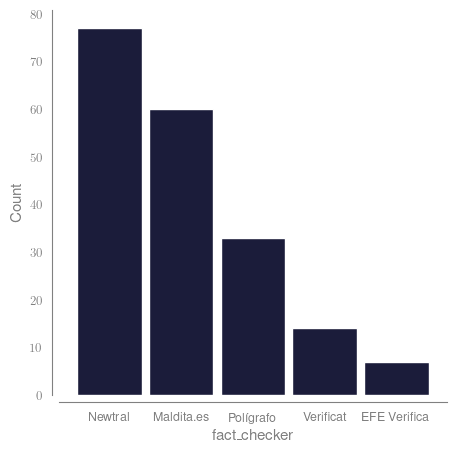

In [24]:
plot_count = plot_counts(field_counts, field)

##### Per day

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


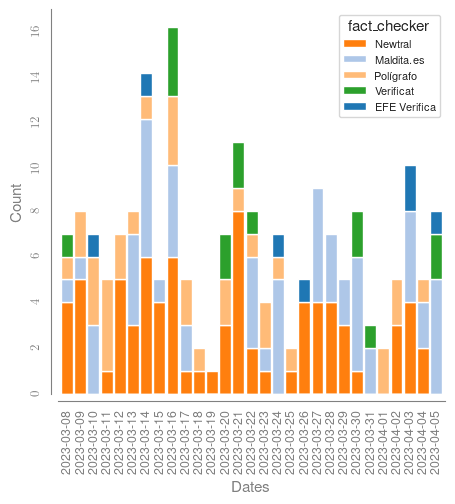

In [25]:
plot_day= plot_per_day(field_dates, field, colours_fact_checker)

#### Qualification of claim

In [26]:
field = 'qualification'

# Define the colour for the fact-checker to be coherent
colours_qualification_claims = define_colours(df_iberifier, field)

# Get the counts
field_counts = get_values_count(df_iberifier, field)

# Get per days
field_dates, field_dates_norm = output_df_for_cross(df_iberifier, 'date', field, reorder_first=False, reorder_second=True)

##### Table

In [27]:
field_counts.to_csv(f"./tables/{sample}_proportion_{field}.csv")
field_counts

,qualification,Counts,Percentages
0,Falso,124,64.9
1,Verdadero / Verdadeiro,24,12.6
2,Explainer,22,11.5
3,Engañoso / Enganador,13,6.8
4,No verificable / Não verificável,4,2.1
5,Manipulado,4,2.1


##### Counts Plot

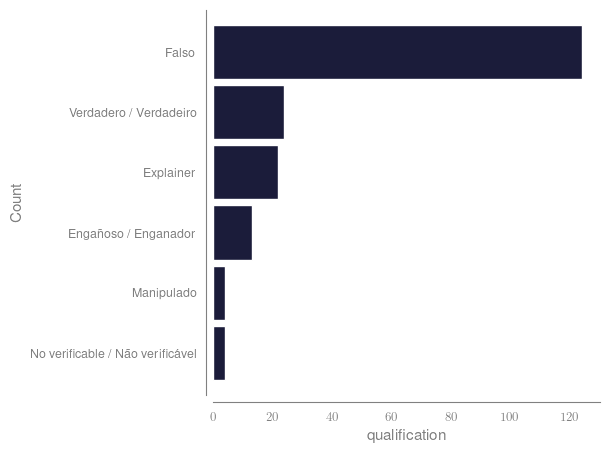

In [28]:
plot_count = plot_counts(field_counts, field, kind_bar='barh')

##### Per day

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


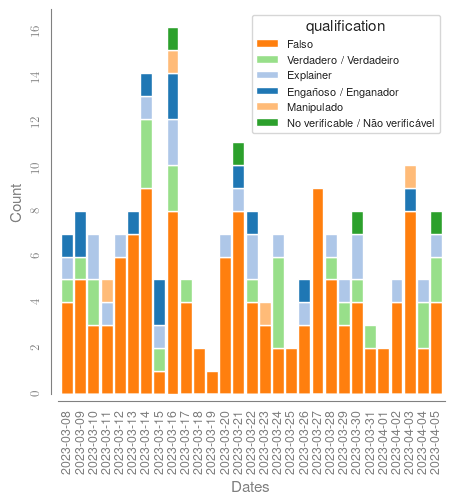

In [29]:
plot_day= plot_per_day(field_dates, field, colours_qualification_claims)

#### Category of claim

In [30]:
field = 'categories'

# Define the colour for the fact-checker to be coherent
colours_cat_claims = define_colours(df_iberifier, field)

# Get the counts
field_counts = get_values_count(df_iberifier, field)

# Get per days
field_dates, field_dates_norm = output_df_for_cross(df_iberifier, 'date', field, reorder_first=False, reorder_second=True)

##### Table

In [31]:
field_counts.to_csv(f"./tables/{sample}_proportion_{field}.csv")
field_counts

,categories,Counts,Percentages
0,Política,64,21.1
1,Social,52,17.1
2,Personajes / Personagens,26,8.6
3,Timo / Fraude,24,7.9
4,Otro / Outros,24,7.9
5,Ciencia / Ciência,21,6.9
6,Salud / Saúde,15,4.9
7,Género / Gênero,15,4.9
8,Consumo,12,3.9
9,Migración/Migraçao - Racismo,11,3.6


##### Counts Plot

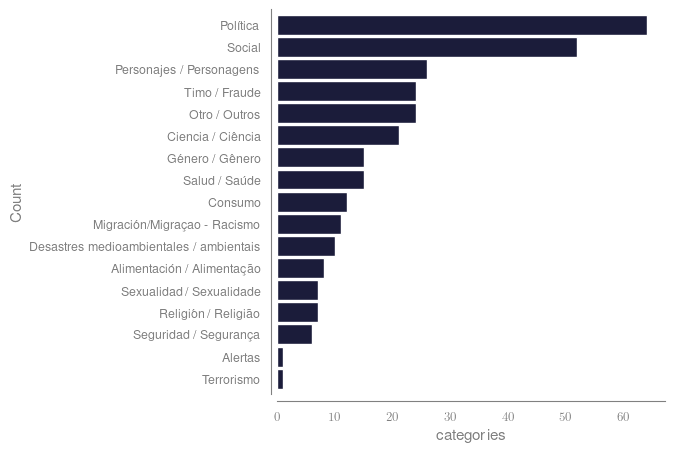

In [32]:
plot_count = plot_counts(field_counts, field, kind_bar='barh')

##### Per day

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


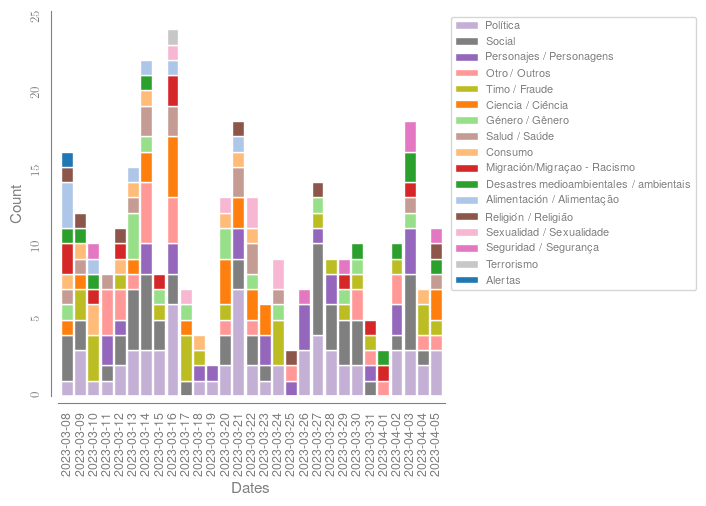

In [33]:
plot_day= plot_per_day(field_dates, field, colours_cat_claims, legend_position=(1, 1))

#### Source of claim

In [34]:
field = 'sources'

# Define the colour for the fact-checker to be coherent
colours_source_claims = define_colours(df_iberifier, field)

# Get the counts
field_counts = get_values_count(df_iberifier, field)

# Get per days
field_dates, field_dates_norm = output_df_for_cross(df_iberifier, 'date', field, reorder_first=False, reorder_second=True)

##### Table

In [35]:
field_counts.to_csv(f"./tables/{sample}_proportion_{field}.csv")
field_counts

,sources,Counts,Percentages
0,Twitter,81,28.9
1,Facebook,77,27.5
2,Otros / Outros,63,22.5
3,WhatsApp,27,9.6
4,TikTok,20,7.1
5,Telegram,5,1.8
6,Buscador,4,1.4
7,Instagram,3,1.1


##### Counts Plot

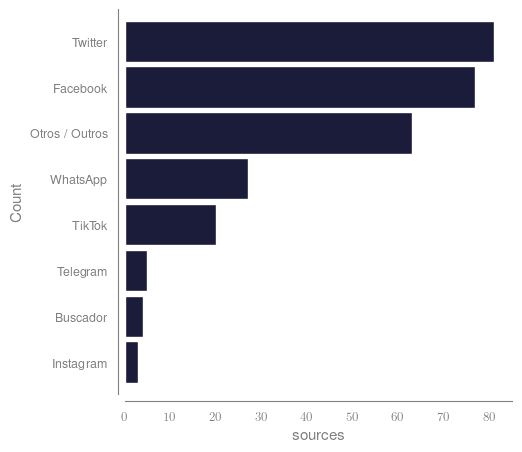

In [36]:
plot_count = plot_counts(field_counts, field, kind_bar='barh')

##### Per day

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


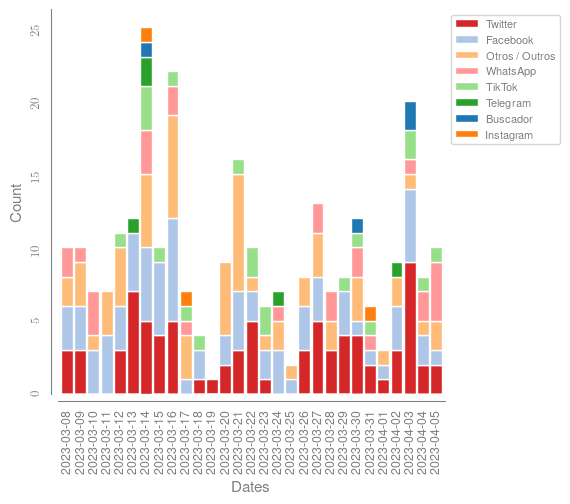

In [37]:
plot_day= plot_per_day(field_dates, field, colours_source_claims, legend_position=(1,1))

#### Type of false information

In [38]:
field = 'type'

# Define the colour for the fact-checker to be coherent
colours_type_claims = define_colours(df_iberifier, field)

# Get the counts
field_counts = get_values_count(df_iberifier, field)

# Get per days
field_dates, field_dates_norm = output_df_for_cross(df_iberifier, 'date', field, reorder_first=False, reorder_second=True)

##### Table

In [39]:
field_counts.to_csv(f"./tables/{sample}_proportion_{field}.csv")
field_counts

,type,Counts,Percentages
0,Contexto falso - Información / Informação falsa,49,25.7
1,Otros / Outros,43,22.5
2,Contenido/Conteúdo manipulado,26,13.6
3,Cita falsa / Citação falsa,23,12.0
4,Timo / Fraude,17,8.9
5,Invent,17,8.9
6,None,10,5.2
7,Alerta falsa/falso,5,2.6
8,Sátira,1,0.5


##### Counts Plot

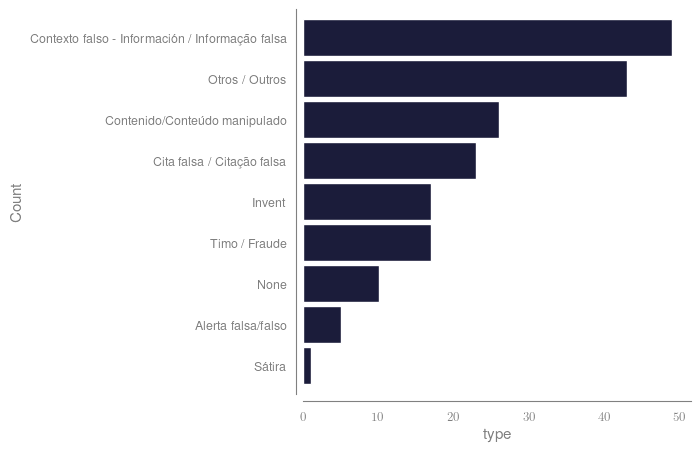

In [40]:
plot_count = plot_counts(field_counts, field, kind_bar='barh')

##### Per day

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


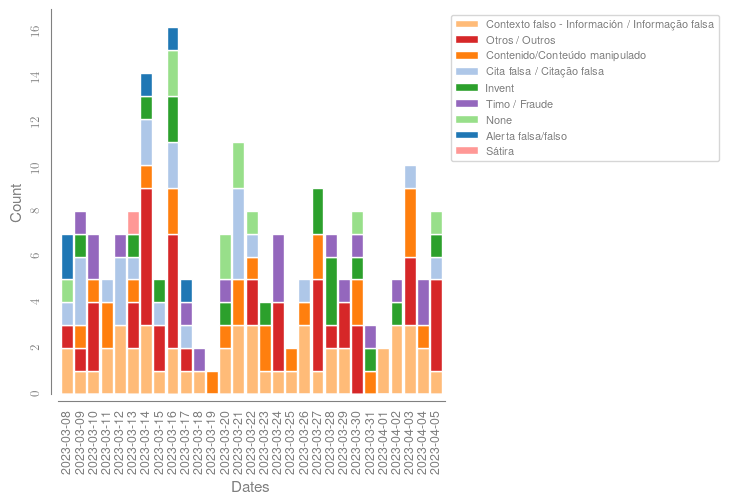

In [41]:
plot_day= plot_per_day(field_dates, field, colours_type_claims, legend_position=(1, 1))

### Crossing columns

#### Fact-checker VS Qualifications

In [42]:
field1 = 'fact_checker'
field2 = 'qualification'
color_palette = colours_qualification_claims
df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

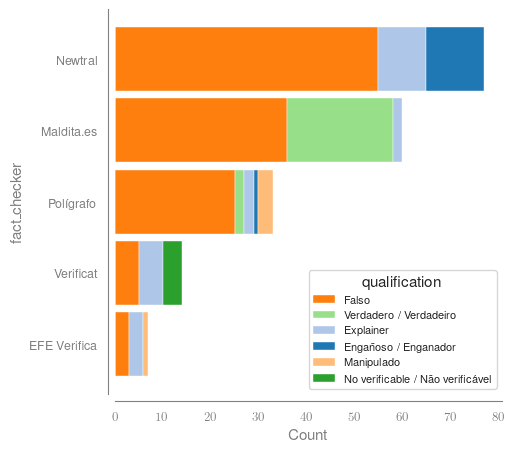

In [43]:
plot_cross(df_to_plot, field1, field2, color_palette, legend_position=None, width_bar=0.9, norm=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

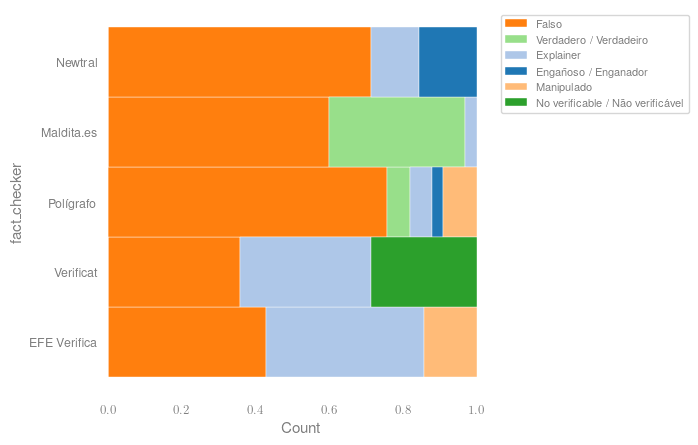

In [44]:
plot_cross(df_to_plot_norm, field1, field2, colours=color_palette, legend_position=(1, 1), norm=True)

#### Fact-checker VS Category

In [45]:
field1 = 'fact_checker'
field2 = 'categories'
color_palette = colours_cat_claims

df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

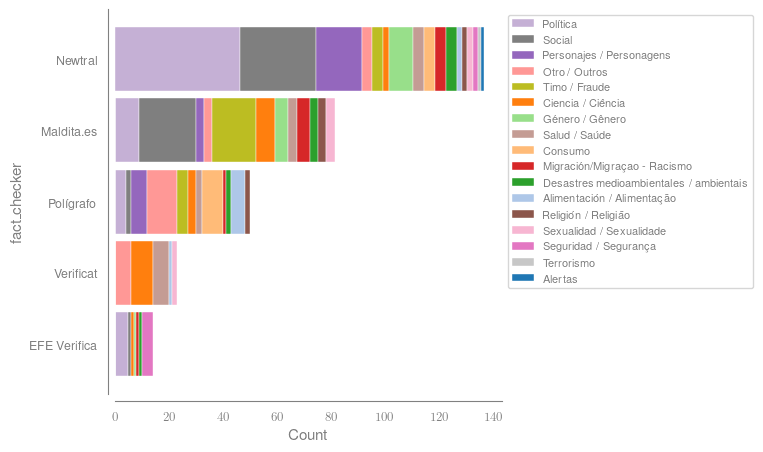

In [46]:
plot_cross(df_to_plot, field1, field2, color_palette, legend_position=(1,1), width_bar=0.9, norm=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

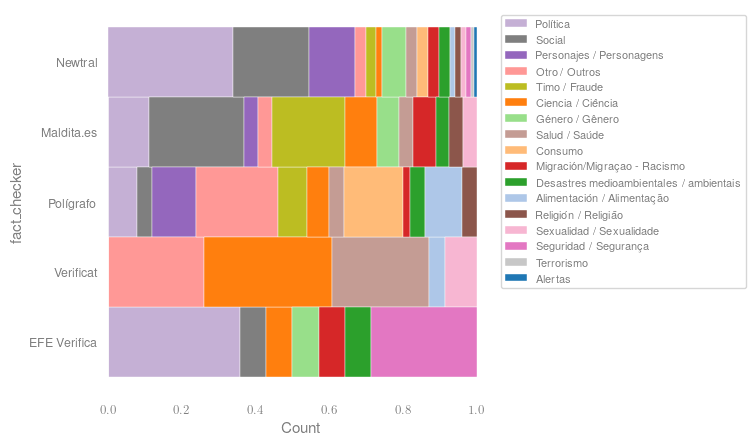

In [47]:
plot_cross(df_to_plot_norm, field1, field2, colours=color_palette, legend_position=(1, 1), norm=True)

#### Fact-checker VS Sources

In [48]:
field1 = 'fact_checker'
field2 = 'sources'
color_palette = colours_source_claims

df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

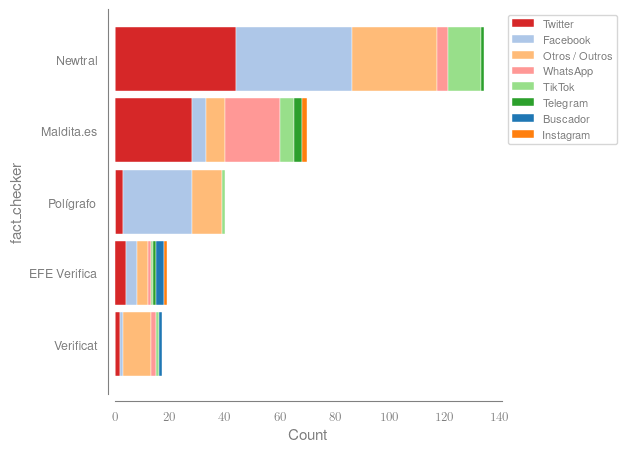

In [49]:
plot_cross(df_to_plot, field1, field2, color_palette, legend_position=(1,1), width_bar=0.9, norm=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

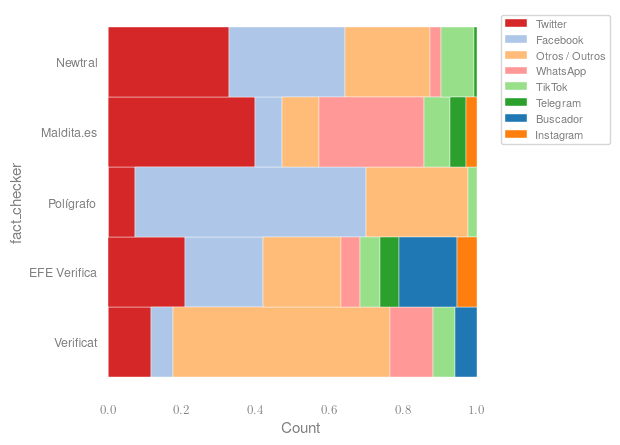

In [50]:
plot_cross(df_to_plot_norm, field1, field2, colours=color_palette, legend_position=(1, 1), norm=True)

#### Fact-checker VS Type of false info

In [51]:
field1 = 'fact_checker'
field2 = 'type'
color_palette = colours_type_claims

df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

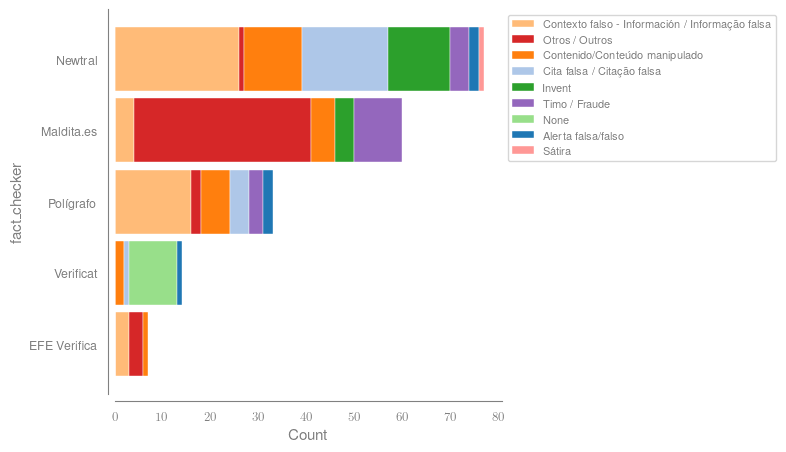

In [52]:
plot_cross(df_to_plot, field1, field2, color_palette, legend_position=(1,1), width_bar=0.9, norm=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

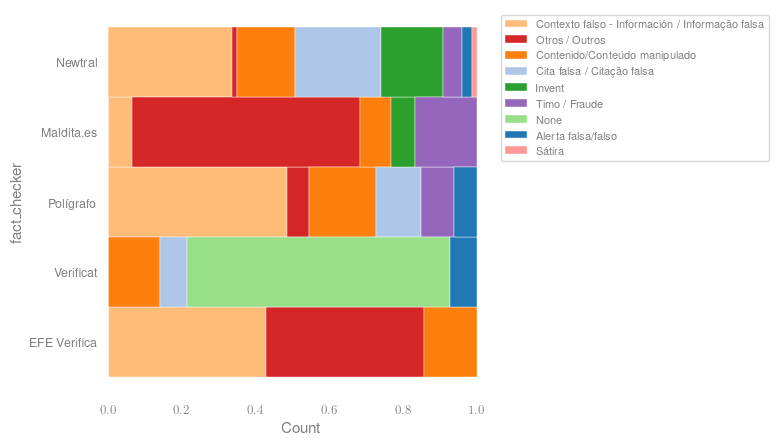

In [53]:
plot_cross(df_to_plot_norm, field1, field2, colours=color_palette, legend_position=(1, 1), norm=True)

#### Qualification VS Category

In [54]:
field1 = 'qualification'
field2 = 'categories'
color_palette = colours_cat_claims

df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

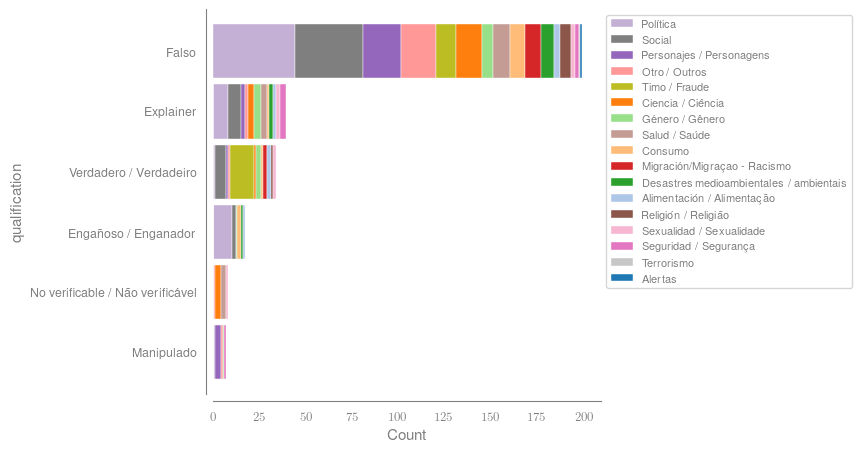

In [55]:
plot_cross(df_to_plot, field1, field2, color_palette, legend_position=(1,1), width_bar=0.9, norm=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

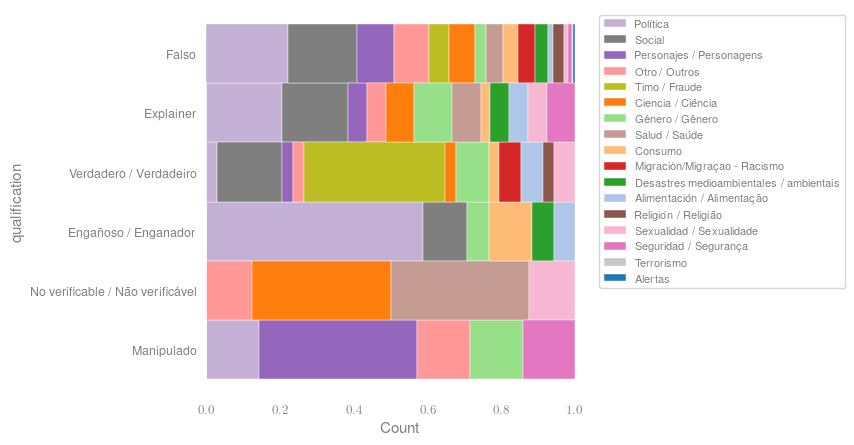

In [56]:
plot_cross(df_to_plot_norm, field1, field2, colours=color_palette, legend_position=(1, 1), norm=True)

#### Qualification VS Source

In [57]:
field1 = 'qualification'
field2 = 'sources'
color_palette = colours_source_claims

df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

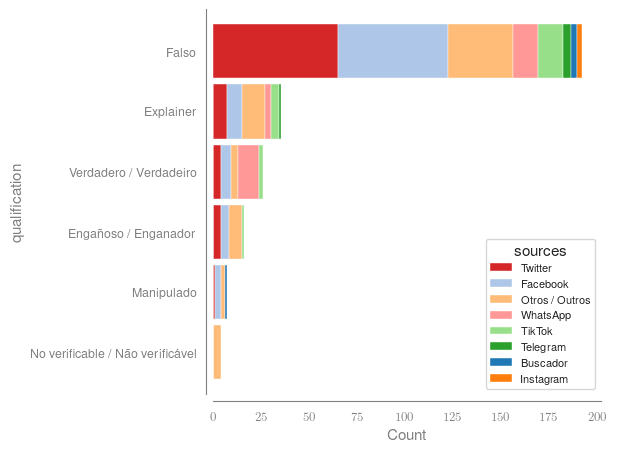

In [58]:
plot_cross(df_to_plot, field1, field2, color_palette, width_bar=0.9, norm=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

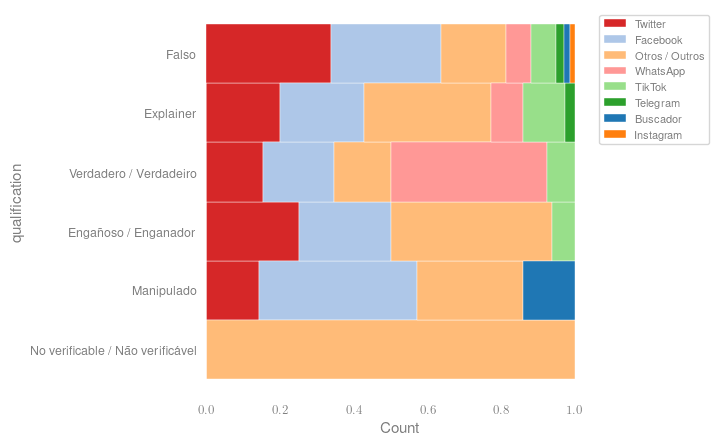

In [59]:
plot_cross(df_to_plot_norm, field1, field2, colours=color_palette, legend_position=(1, 1), norm=True)

#### Qualification VS Type of False info

In [60]:
field1 = 'qualification'
field2 = 'type'
color_palette = colours_type_claims

df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

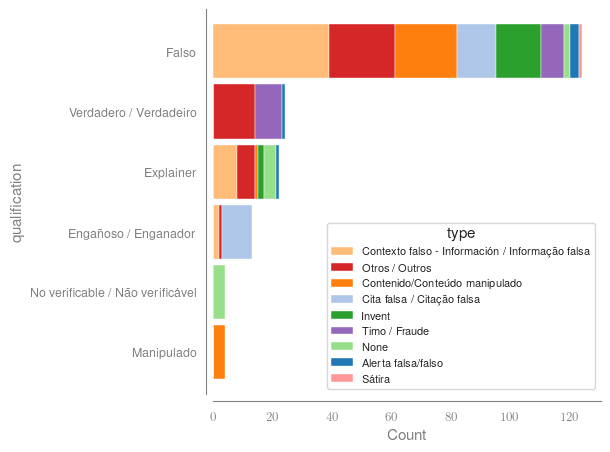

In [61]:
plot_cross(df_to_plot, field1, field2, color_palette, width_bar=0.9, norm=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

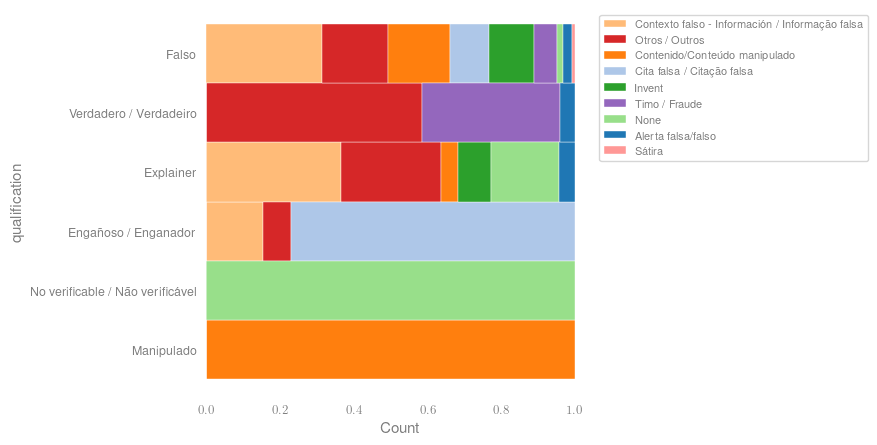

In [62]:
plot_cross(df_to_plot_norm, field1, field2, colours=color_palette, legend_position=(1, 1), norm=True)

#### Category VS Source

In [63]:
field1 = 'categories'
field2 = 'sources'
color_palette = colours_source_claims

df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

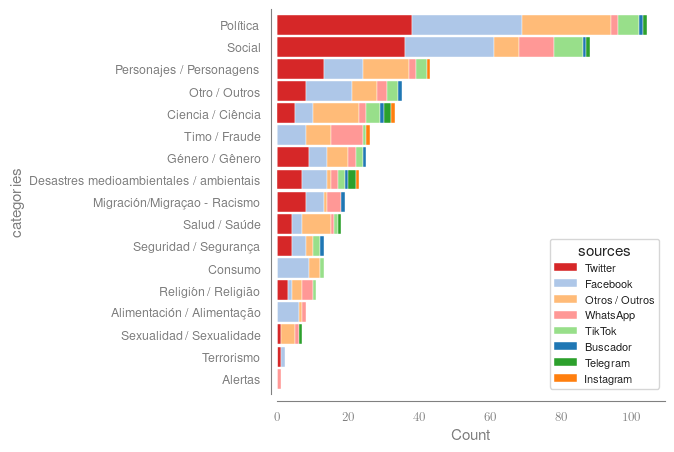

In [64]:
plot_cross(df_to_plot, field1, field2, color_palette, width_bar=0.9, norm=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

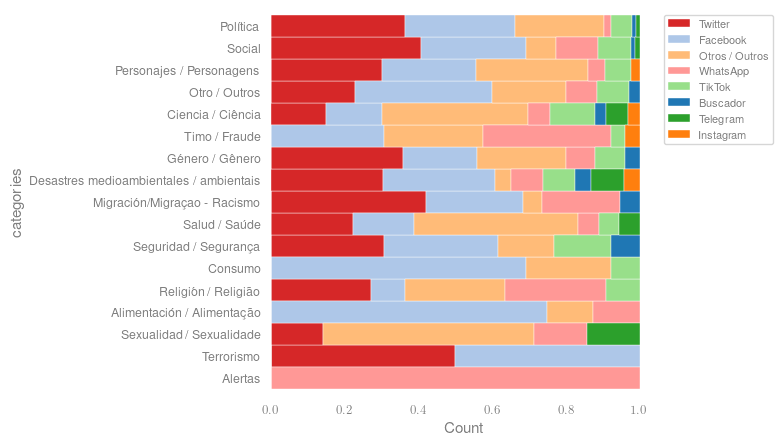

In [65]:
plot_cross(df_to_plot_norm, field1, field2, colours=color_palette, legend_position=(1, 1), norm=True)

#### Category VS Type of False info

In [66]:
field1 = 'categories'
field2 = 'type'
color_palette = colours_type_claims

df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

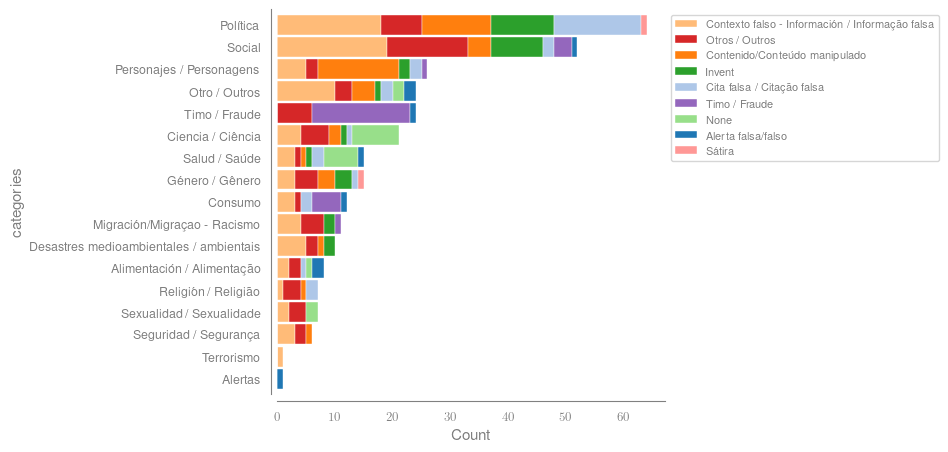

In [67]:
plot_cross(df_to_plot, field1, field2, color_palette, legend_position=(1,1), width_bar=0.9, norm=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

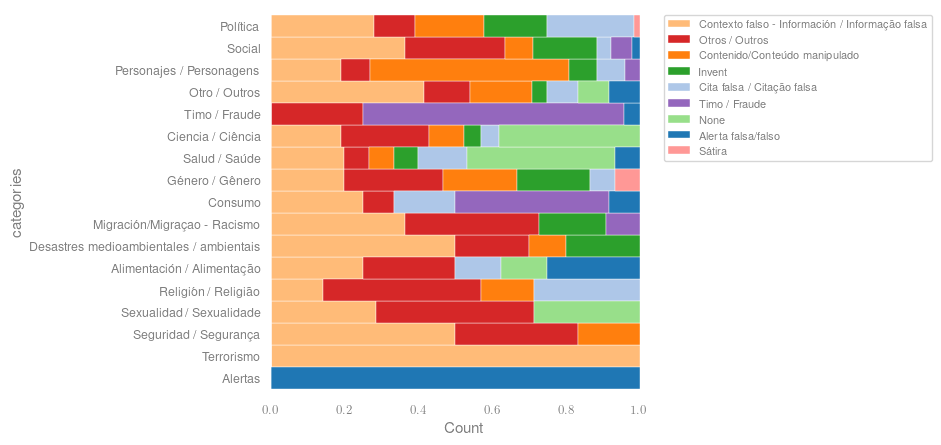

In [68]:
plot_cross(df_to_plot_norm, field1, field2, colours=color_palette, legend_position=(1, 1), norm=True)

#### Source VS Type of False info

In [69]:
field1 = 'sources'
field2 = 'type'
color_palette = colours_type_claims

df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

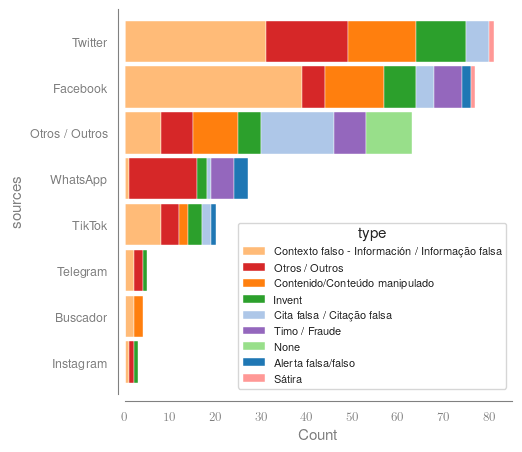

In [70]:
plot_cross(df_to_plot, field1, field2, color_palette, width_bar=0.9, norm=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

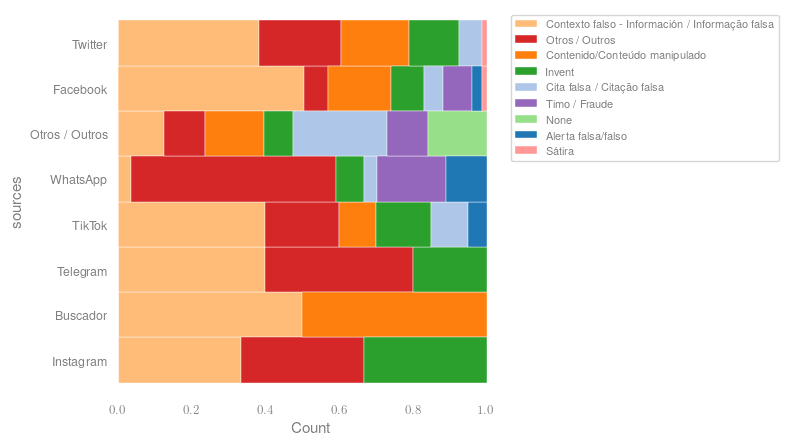

In [71]:
plot_cross(df_to_plot_norm, field1, field2, colours=color_palette, legend_position=(1, 1), norm=True)

## Information about the Twitter API

#### Network between fact_id

In [72]:
# Get the number of fact_id per tweets
df_tweets['nbr_facts'] = df_tweets['fact_id'].apply(lambda x: len(x))
# Explode tweets on fact_id list
tweets_exploded = df_tweets.explode('fact_id')

iberifier_columns = ['date', 'sources', 'fact_id', 'categories', 'type', 'fact_checker', 'qualification']
# Merge the iberifier onto the tweets based on the fact_id
tweets_iberifier = pd.merge(tweets_exploded, df_iberifier[iberifier_columns], on='fact_id', how='left')

# Rename the date to avoid confusion
tweets_iberifier = tweets_iberifier.rename(columns={'date_x': 'date_tweet', 'date_y': 'date_fact_check'})
len(tweets_iberifier)

4942

In [73]:
tweets_iberifier.describe()

,retweet_count,reply_count,like_count,quote_count,impression_count,nbr_facts
count,4942.000000,4942.000000,4942.000000,4942.000000,4.942000e+03,4942.000000
mean,13.724808,4.166532,42.243626,1.030352,3.755901e+03,1.087819
std,171.907836,90.071466,678.212001,13.280279,4.667467e+04,0.285197
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000
25%,0.000000,0.000000,0.000000,0.000000,2.500000e+01,1.000000
50%,0.000000,0.000000,0.000000,0.000000,1.020000e+02,1.000000
75%,1.000000,1.000000,3.000000,0.000000,5.795000e+02,1.000000
max,8618.000000,5976.000000,41452.000000,450.000000,2.596463e+06,3.000000


## Amount of tweets per fact_check features

In [74]:
def match_tweet_factcheck_feature(df, feature_columns):
    try:
        group_feature = df.groupby(['fact_id', feature_columns]).size()

    except TypeError: # In case it is a list
        group_feature = df.explode(feature_columns).groupby(['fact_id', feature_columns]).size()
    group_feature = group_feature.reset_index(level='fact_id', drop=True).reset_index()#.sort_values(by=0, ascending=False)
    #group_feature = group_feature.assign(tmp=group_feature.sum(axis=1)).sort_values('tmp', ascending=True).drop(labels='tmp', axis=1)

    return group_feature

In [75]:
def plot_box_tweets(df, feature_columns, color_scheme, legend_position=None,):
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.despine(offset=5, trim=False);

    filename = f"tweets_{feature_columns}"
    order = df.groupby(feature_column).sum().sort_values(by=0, ascending=False).index

    #fig.suptitle(f"{field1} and {field2} of claims [{min(df_iberifier['date'])} - {max(df_iberifier['date'])}]")
    plot = sns.boxplot(grouped_data, y=feature_column, palette= color_scheme, x=0, showfliers = False, order=order)
    ax.set(xlabel=f'')
    ax.set(ylabel=f'')

    ax.tick_params(rotation=0)
    save_plot(fig, ax, filename, sample, legend_position=legend_position)

    
    return plot

#### Qualification

In [76]:
feature_column = 'qualification'
color_scheme = colours_qualification_claims

grouped_data = match_tweet_factcheck_feature(tweets_iberifier, feature_column)
stats_per_features = grouped_data.groupby(feature_column).describe()
stats_per_features.to_csv(f"./tables/{sample}_tweets_per_{feature_column}.csv")
stats_per_features

0                                                    
              count       mean         std  min  25%   50%   75%    max
qualification                                                          
Falso          62.0  78.725806  146.038415  1.0  5.0  11.5  49.0  570.0

<AxesSubplot: >

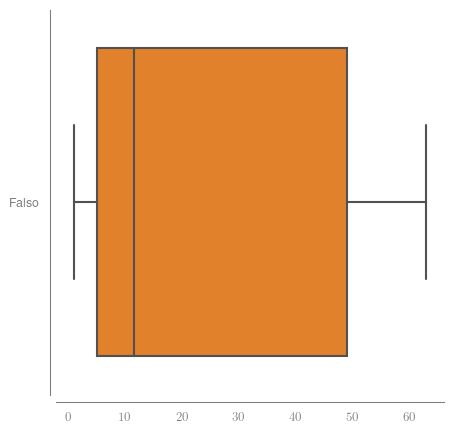

In [77]:
plot_box_tweets(grouped_data, feature_column, color_scheme)

#### Categories

In [78]:
feature_column = 'categories'
color_scheme = colours_cat_claims
grouped_data = match_tweet_factcheck_feature(tweets_iberifier, feature_column)
stats_per_features = grouped_data.groupby(feature_column).describe()
stats_per_features.to_csv(f"./tables/{sample}_tweets_per_{feature_column}.csv")
stats_per_features

0                                \
                                        count        mean         std   min   
categories                                                                    
Ciencia / Ciência                         6.0   55.166667  102.053744   4.0   
Desastres medioambientales / ambientais   2.0    6.000000    5.656854   2.0   
Género / Gênero                           3.0    3.666667    2.516611   1.0   
Migración/Migraçao - Racismo              4.0   75.000000   97.921737   8.0   
Otro / Outros                             1.0    7.000000         NaN   7.0   
Personajes / Personagens                 16.0  101.750000  199.475145   1.0   
Política                                 32.0   78.031250  145.247616   1.0   
Religión / Religião                       3.0   98.333333  135.699423   5.0   
Salud / Saúde                             3.0    8.666667    5.033223   4.0   
Seguridad / Segurança                     1.0    4.000000         NaN   4.0   
Sexualidad / Sexualidade                  1.0    1.000000         NaN   1.0   
Social                                   24.0   93.708333  160.809495   1.0   
Terrorismo                                1.0   32.000000         NaN  32.0   
Timo / Fraude                             4.0    5.500000    4.795832   1.0   

                                                                     
                                           25%   50%     75%    max  
categories                                                           
Ciencia / Ciência                         9.50  16.5   22.00  263.0  
Desastres medioambientales / ambientais   4.00   6.0    8.00   10.0  
Género / Gênero                           2.50   4.0    5.00    6.0  
Migración/Migraçao - Racismo             11.00  37.5  101.50  217.0  
Otro / Outros                             7.00   7.0    7.00    7.0  
Personajes / Personagens                  4.75  10.0   23.25  558.0  
Política                                  6.75  11.0   38.50  558.0  
Religión / Religião                      20.50  36.0  145.00  254.0  
Salud / Saúde                             6.00   8.0   11.00   14.0  
Seguridad / Segurança                     4.00   4.0    4.00    4.0  
Sexualidad / Sexualidade                  1.00   1.0    1.00    1.0  
Social                                    5.00  14.5   78.75  570.0  
Terrorismo                               32.00  32.0   32.00   32.0  
Timo / Fraude                             2.50   4.5    7.50   12.0

<AxesSubplot: >

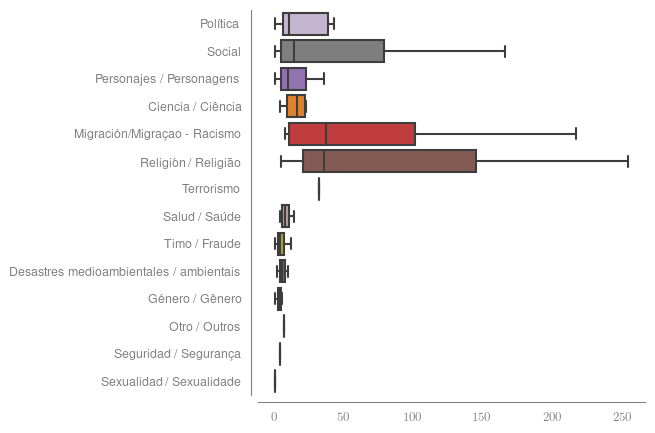

In [79]:
plot_box_tweets(grouped_data, feature_column, color_scheme)

#### Sources

In [80]:
feature_column = 'sources'
color_scheme = colours_source_claims
grouped_data = match_tweet_factcheck_feature(tweets_iberifier, feature_column)
stats_per_features = grouped_data.groupby(feature_column).describe()
stats_per_features.to_csv(f"./tables/{sample}_tweets_per_{feature_column}.csv")
stats_per_features

0                                                          
               count        mean         std  min    25%    50%     75%    max
sources                                                                       
Buscador         1.0    8.000000         NaN  8.0   8.00    8.0    8.00    8.0
Facebook        23.0   31.130435   57.885706  1.0   6.50   12.0   25.50  265.0
Instagram        2.0    4.500000    4.949747  1.0   2.75    4.5    6.25    8.0
Otros / Outros  16.0   67.687500  147.602493  1.0   3.75    6.0   39.75  558.0
TikTok           8.0   47.000000   89.742489  4.0   4.75   11.5   28.25  265.0
Twitter         41.0   74.926829  135.086156  1.0   6.00   12.0   43.00  570.0
WhatsApp         7.0  229.714286  243.968382  1.0  14.00  217.0  396.00  570.0

In [81]:
grouped_data#.groupby('sources').sum()

,sources,0
0,Otros / Outros,263
1,WhatsApp,217
2,Twitter,8
3,Facebook,63
4,Twitter,63
...,...,...
93,TikTok,4
94,Twitter,4
95,Otros / Outros,124
96,Twitter,124


<AxesSubplot: >

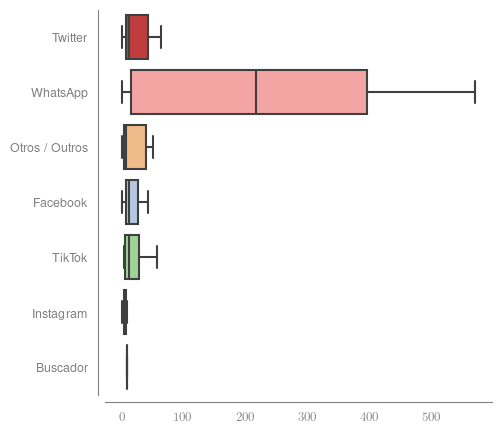

In [82]:
plot_box_tweets(grouped_data, feature_column, color_scheme)

#### Type

In [83]:
feature_column = 'type'
color_scheme = colours_type_claims
grouped_data = match_tweet_factcheck_feature(tweets_iberifier, feature_column)
stats_per_features = grouped_data.groupby(feature_column).describe()
stats_per_features.to_csv(f"./tables/{sample}_tweets_per_{feature_column}.csv")
stats_per_features

0                          \
                                                count        mean         std   
type                                                                            
Cita falsa / Citação falsa                        3.0    5.000000    2.645751   
Contenido/Conteúdo manipulado                    14.0  108.214286  182.370788   
Contexto falso - Información / Informação falsa  16.0   60.125000  113.903395   
Invent                                           12.0   19.500000   20.743016   
Otros / Outros                                   14.0  152.428571  196.429950   
Timo / Fraude                                     3.0    7.000000    4.582576   

                                                                          \
                                                 min   25%   50%     75%   
type                                                                       
Cita falsa / Citação falsa                       3.0  3.50   4.0    6.00   
Contenido/Conteúdo manipulado                    1.0  5.25  13.0  102.00   
Contexto falso - Información / Informação falsa  1.0  7.25  12.5   34.75   
Invent                                           4.0  6.75   9.0   22.75   
Otros / Outros                                   1.0  5.75  41.0  244.75   
Timo / Fraude                                    3.0  4.50   6.0    9.00   

                                                        
                                                   max  
type                                                    
Cita falsa / Citação falsa                         8.0  
Contenido/Conteúdo manipulado                    558.0  
Contexto falso - Información / Informação falsa  403.0  
Invent                                            63.0  
Otros / Outros                                   570.0  
Timo / Fraude                                     12.0

<AxesSubplot: >

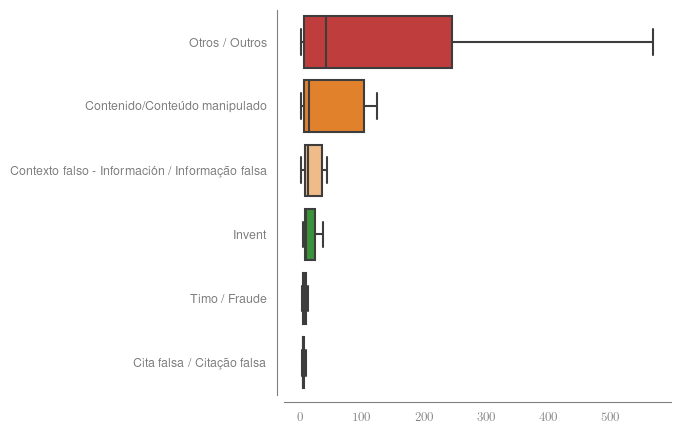

In [84]:
plot_box_tweets(grouped_data, feature_column, color_scheme)

## Information about MyNews API data collection

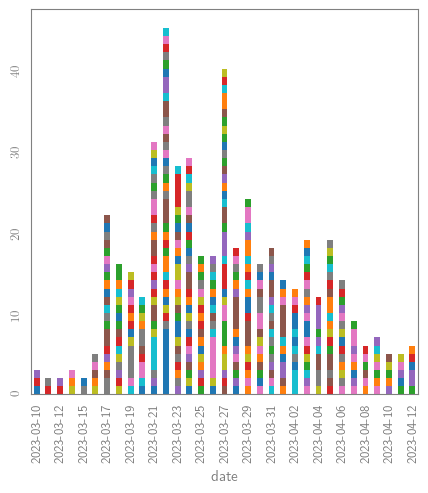

In [85]:
sns.set_style("white")
fig, ax = plt.subplots()

df_mynews.groupby([df_mynews['date'], df_mynews['Newspaper']]).size().unstack().plot.bar(stacked=True, 
                                                                                         ax=ax, 
                                                                                         linewidth=0,
                                                                                         legend=False)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.tick_params(rotation=90)


#plt.tight_layout()

filename = f'newspaper_overtime_cat'
save_plot(fig, ax, filename, sample)

#plt.savefig('./plots/newspaper_overtime.png', bbox_inches='tight')
plt.show()

## Newspaper parsed

In [86]:
unique_newspapers = df_mynews['Newspaper'].unique().size
unique_newspapers

285

[Text(0.5, 0, 'Numbers of News article per claim')]

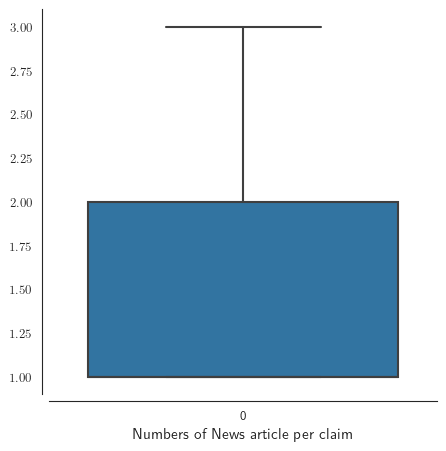

In [87]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(5, 5))

sns.despine(offset=5, trim=False);
sns.boxplot(df_mynews.groupby(['Newspaper'] ).size(), showfliers = False)
ax.set(xlabel='Numbers of News article per claim')

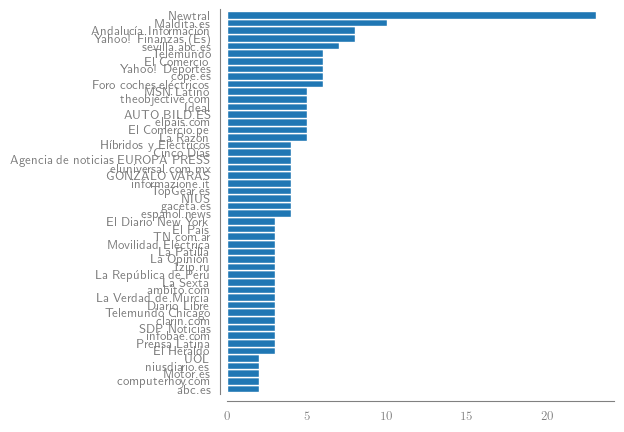

In [88]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(5, 10))

sns.despine(offset=5, trim=False);

df_mynews['Newspaper'].value_counts(ascending=False).head(50).sort_values(ascending=True).plot(kind='barh', ax=ax, width=1)

#plt.tight_layout()


filename = f'top_50_journals'
save_plot(fig, ax, filename, sample, png_size=(5,10), eps_size=(5,10))


plt.show()

## Distribution of tweets and news articles per claims

In [89]:
# Tweets
# Need to explode the list in fact_id before groupby
df_exploded = df_tweets.explode('fact_id')
tweets_grouped = df_exploded.groupby('fact_id').size()#.mean()
#sns.violinplot(data=tweets_grouped, inner='points', cut=0)

# For mynews
mynews_grouped = df_mynews.groupby('fact_id').size()
mynews_grouped

# Concat
count_per_claim = pd.concat([tweets_grouped, mynews_grouped], axis=1, keys=['count_tweets', 'count_articles']).reset_index()
count_per_claim = count_per_claim.fillna(0)
count_per_claim['count_tweets'] = count_per_claim['count_tweets'].astype('int') 
count_per_claim['count_articles'] = count_per_claim['count_articles'].astype('int') 
stat_count_per_claims = count_per_claim.describe().applymap('{:,.1f}'.format)
stat_count_per_claims.to_csv(f"./tables/{sample}stat_count_per_claims.csv")
stat_count_per_claims

,count_tweets,count_articles
count,66.0,66.0
mean,74.9,7.5
std,142.4,13.8
min,0.0,0.0
25%,5.0,1.0
50%,10.5,3.0
75%,49.0,5.8
max,570.0,67.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


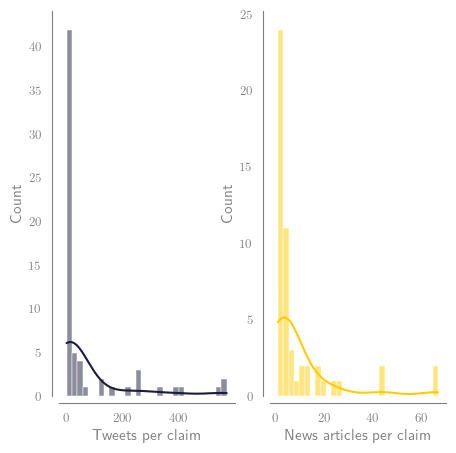

In [90]:
sns.set_style("white")

fig, ax = plt.subplots(1,2)
#fig.suptitle('Distribution of Tweets and news articles per claim')
sns.despine(offset=5, trim=False);

sns.histplot(tweets_grouped, kde=True, ax=ax[0], bins=30, label='Tweets', color=main_color)
ax[0].set(xlabel='Tweets per claim')

sns.histplot(mynews_grouped, kde=True,  ax=ax[1], bins=30, label="News articles", color=second_color)
ax[1].set(xlabel='News articles per claim')


filename = f'tweets_news_per_claims_hist'
save_plot(fig, ax, filename, sample)

plt.show()

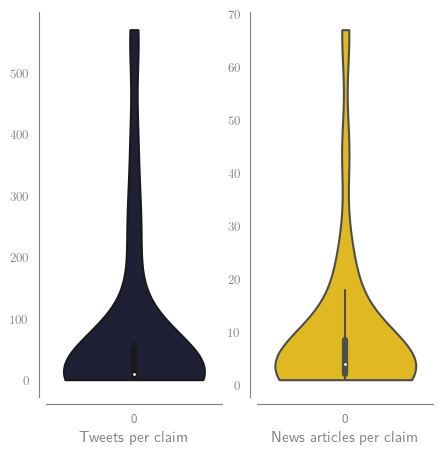

In [91]:
sns.set_style("white")

fig, ax = plt.subplots(1,2)
#fig.suptitle('Distribution of Tweets and news articles per claim')
sns.despine(offset=5, trim=False);

sns.violinplot(tweets_grouped, kde=True, ax=ax[0],  label='Tweets', color=main_color, cut=0)
ax[0].set(xlabel='Tweets per claim')

sns.violinplot(mynews_grouped, kde=True,  ax=ax[1], label="News articles", color=second_color, cut=0)
ax[1].set(xlabel='News articles per claim')


filename = f'tweets_news_per_claims_violin'
save_plot(fig, ax, filename, sample)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


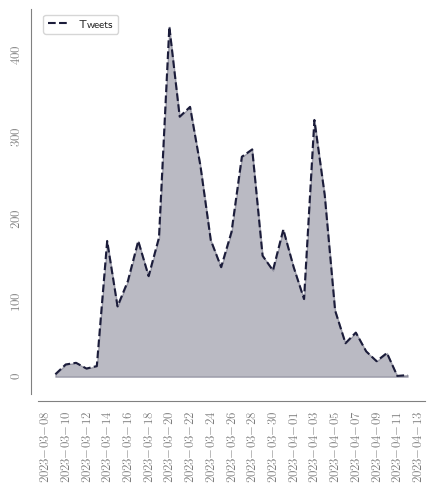

In [92]:
tweets = df_tweets.groupby(df_tweets['date']).size()

fig, ax = plt.subplots()

sns.despine(offset=5, trim=False);

ax.plot_date(tweets.index, tweets.values, '--', label='Tweets', color=main_color)


ax.fill_between(tweets.index, tweets.values, alpha=0.3, color=main_color)


ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.tick_params(rotation=90)
ax.legend(loc='upper left')


filename = f'tweets_overtime'
save_plot(fig, ax, filename, sample)


plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


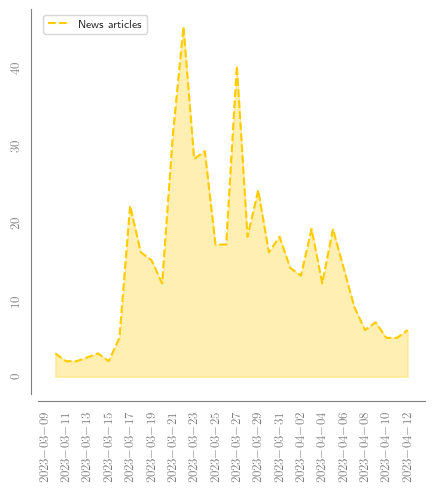

In [93]:
mynews = df_mynews.groupby(df_mynews['date']).size()

fig, ax = plt.subplots()

sns.despine(offset=5, trim=False);


ax.plot_date(mynews.index, mynews.values, '--', label='News articles', color=second_color)

ax.fill_between(mynews.index, mynews.values, alpha=0.3, color=second_color)


ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.tick_params(rotation=90)
ax.legend(loc='upper left')


filename = f'mynews_overtime'
save_plot(fig, ax, filename, sample)


plt.show()

### Merged plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


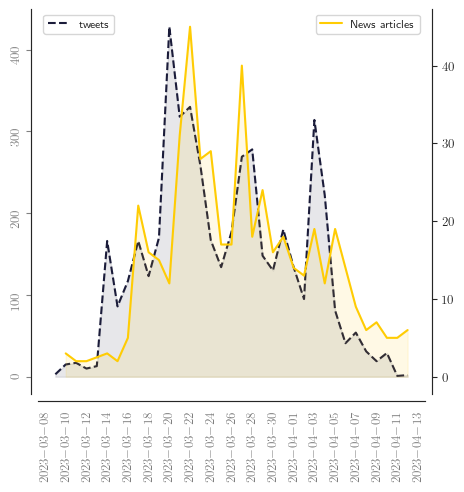

In [94]:
sns.set_style("white")

fig, ax = plt.subplots()

sns.despine(offset=5, trim=False);

ax.plot_date(tweets.index, tweets.values, '--', label='tweets', color=main_color)


ax.fill_between(tweets.index, tweets.values, alpha=0.1, color=main_color)

ax2 = ax.twinx()
ax2.plot_date(mynews.index, mynews.values, '-', label='News articles', color=second_color)
ax2.fill_between(mynews.index, mynews.values, alpha=0.1, color=second_color)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.tick_params(rotation=90)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
sns.despine(offset=5, trim=False, right=False);


filename = f'tweets_news_overtime'
save_plot(fig, ax, filename, sample)


plt.show()

# Impact of fact check

In [95]:
# The only interest here is on the outliers versus no outliers. All the data will come with the 'on_topic'
# So sample will be 
# outliers and wo_outliers
if sample == 'wo_outliers':
    pass

In [96]:
# Calculate the difference in time between the time the tweet is published and the fact-check
tweets_iberifier['diff_date'] = (tweets_iberifier['date_tweet'] - tweets_iberifier['date_fact_check']).dt.days
tweets_iberifier['diff_date'] = tweets_iberifier['diff_date'].fillna(0)
tweets_iberifier['diff_date'] = tweets_iberifier['diff_date'].astype('int') 

# Groupby and get the impact size for each of fact_id - Fill nan with 0 as it means nothing was collected before

                                                                                                  
             
# Create the diff date for the plot
diff_date = tweets_iberifier.groupby(['fact_id', 'diff_date']).size().reset_index()
diff_date_per_factchecker = tweets_iberifier.groupby(['fact_id', 'diff_date', 'fact_checker']).size().reset_index()[['diff_date', 'fact_checker', 0]]
diff_date_per_support_claim = tweets_iberifier.groupby(['fact_id', 'diff_date', 'claim_finer_relation']).size().reset_index()[['diff_date', 'claim_finer_relation', 0]]

## Grouping by tweets metrics
diff_date_metrics = tweets_iberifier.groupby(['fact_id', 'diff_date']).agg({'retweet_count': 'sum', 
                                                              'reply_count': 'sum', 
                                                              'like_count': 'sum',
                                                              'quote_count': 'sum',
                                                              'impression_count': 'sum'})

diff_date_metrics_support_claim = tweets_iberifier.groupby(['fact_id', 'diff_date', 'claim_finer_relation']).agg({'retweet_count': 'sum', 
                                                              'reply_count': 'sum', 
                                                              'like_count': 'sum',
                                                              'quote_count': 'sum',
                                                              'impression_count': 'sum'})

<AxesSubplot: xlabel='diff_date', ylabel='0'>

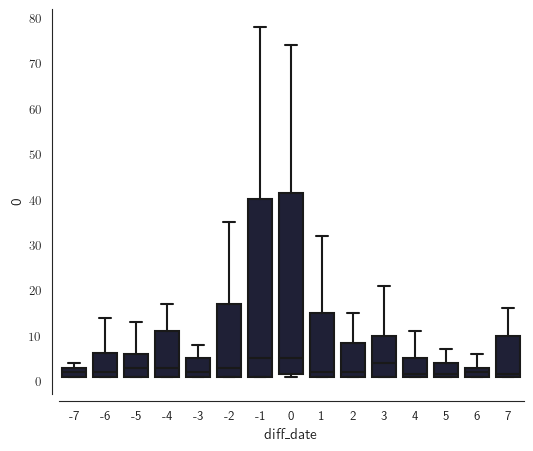

In [97]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(6, 5))

sns.despine(offset=5, trim=False)
sns.boxplot(diff_date, x='diff_date', y=0, color=main_color, showfliers=False)

Text(2.7, 37.607284482758615, 'Fact check publication')

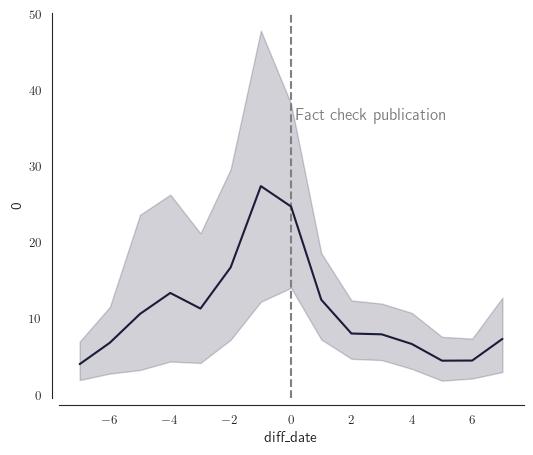

In [129]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(6, 5))

sns.despine(offset=5, trim=False)
ax.axvline(x=0, color='grey', linestyle='--')
ax = sns.lineplot(diff_date, x='diff_date', y=0, color=main_color)
ax.text(x=2.7, y=ax.get_ylim()[1]-ax.get_ylim()[1]/4, s='Fact check publication', fontsize=12, color='grey', bbox={'boxstyle': 'round,pad=0.3', 'ec': 'none', 'fc': 'none'}, ha='center', va='top' )


Text(2.7, 36.66072916666666, 'Fact check publication')

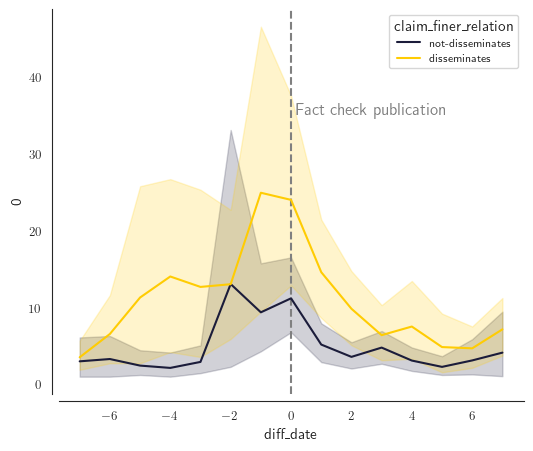

In [127]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(6, 5))
sns.despine(offset=5, trim=False)
ax.axvline(x=0, color='grey', linestyle='--')

ax = sns.lineplot(diff_date_per_support_claim, x='diff_date', hue='claim_finer_relation', y=0, palette=[main_color, second_color])
ax.text(x=2.7, y=ax.get_ylim()[1]-ax.get_ylim()[1]/4, s='Fact check publication', fontsize=12, color='grey', bbox={'boxstyle': 'round,pad=0.3', 'ec': 'none', 'fc': 'none'}, ha='center', va='top' )


Text(2.7, 69.28382812499999, 'Fact check publication')

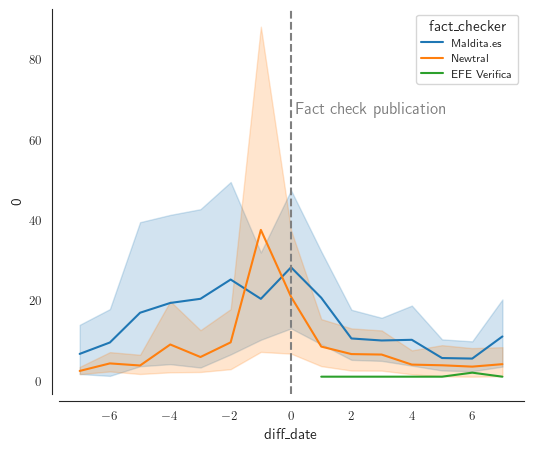

In [126]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(6, 5))

sns.despine(offset=5, trim=False)

ax = sns.lineplot(diff_date_per_factchecker, x='diff_date', hue='fact_checker', y=0)
ax.axvline(x=0, color='grey', linestyle='--')
ax.text(x=2.7, y=ax.get_ylim()[1]-ax.get_ylim()[1]/4, s='Fact check publication', fontsize=12, color='grey', bbox={'boxstyle': 'round,pad=0.3', 'ec': 'none', 'fc': 'none'}, ha='center', va='top' )

### Difference in counts rather than raw number of tweets

Text(2.7, 641.3976041666664, 'Fact check publication')

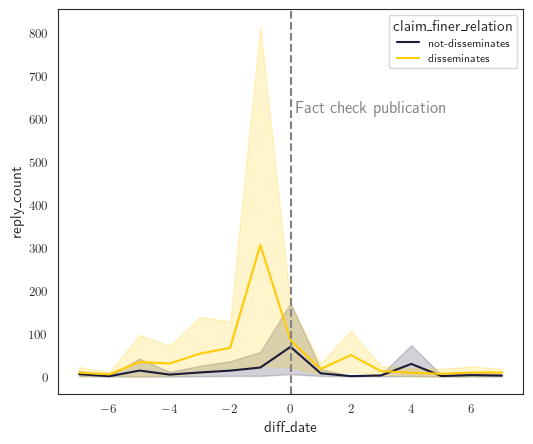

In [124]:
fig, ax = plt.subplots(figsize=(6, 5))

#sns.despine(offset=5, trim=False)



#for col in [retweet_count 	reply_count 	like_count 	quote_count 	impression_count
sns.lineplot(diff_date_metrics_support_claim, x='diff_date', y='reply_count', hue='claim_finer_relation', palette=[main_color, second_color])
ax.axvline(x=0, color='grey', linestyle='--')
ax.text(x=2.7, y=ax.get_ylim()[1]-ax.get_ylim()[1]/4, s='Fact check publication', fontsize=12, color='grey', bbox={'boxstyle': 'round,pad=0.3', 'ec': 'none', 'fc': 'none'}, ha='center', va='top' )

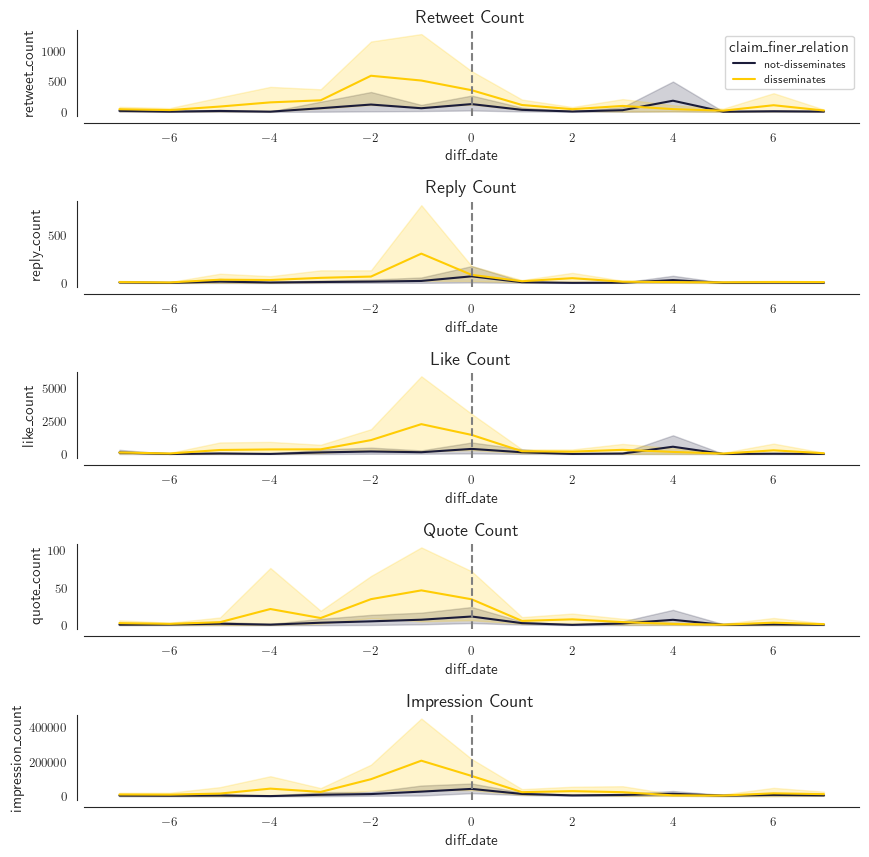

In [102]:
# define the subplots
fig = plt.figure(figsize=(10,10))

gs = GridSpec(nrows=5, ncols=1, hspace=1)
sns.despine(offset=5, trim=False)
# Create the ax
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[3, 0])
ax4 = fig.add_subplot(gs[4, 0])

sns.despine(offset=5, trim=False)


# plot each line in a separate subplot
sns.lineplot(data=diff_date_metrics_support_claim, x='diff_date', y='retweet_count', hue='claim_finer_relation', palette=[main_color, second_color], ax=ax0)
sns.lineplot(data=diff_date_metrics_support_claim, x='diff_date', y='reply_count', hue='claim_finer_relation', palette=[main_color, second_color], ax=ax1, legend=None)

sns.lineplot(data=diff_date_metrics_support_claim, x='diff_date', y='like_count', hue='claim_finer_relation',palette=[main_color, second_color],  ax=ax2, legend=None)

sns.lineplot(data=diff_date_metrics_support_claim, x='diff_date', y='quote_count', hue='claim_finer_relation',palette=[main_color, second_color], ax=ax3, legend=None)

sns.lineplot(data=diff_date_metrics_support_claim, x='diff_date', y='impression_count', hue='claim_finer_relation',palette=[main_color, second_color], ax=ax4, legend=None)


# Draw line for the event

ax0.axvline(x=0, ymax=ax0.get_ylim()[1]/2, color='grey', linestyle='--')
ax1.axvline(x=0, ymax=ax1.get_ylim()[1]/2, color='grey', linestyle='--')
ax2.axvline(x=0, ymax=ax2.get_ylim()[1]/2, color='grey', linestyle='--')
ax3.axvline(x=0, ymax=ax3.get_ylim()[1]/2, color='grey', linestyle='--')
ax4.axvline(x=0, ymax=ax4.get_ylim()[1]/2, color='grey', linestyle='--')

# add titles and axis labels
ax0.set_title('Retweet Count')
ax1.set_title('Reply Count')
ax2.set_title('Like Count')
ax3.set_title('Quote Count')
ax4.set_title('Impression Count')

# create a legend axis
#legend_ax = fig.add_axes([0.85, 0.5, 0.1, 0.1])

# get the handles and labels from each subplot
#handles, labels = [], []
#for ax in axes:
#    for h, l in zip(*ax.get_legend_handles_labels()):
#        handles.append(h)
#        labels.append(l)

# add the legend to the legend axis
#legend_ax.legend(handles, labels, loc='center', title='Fact ID')
plt.show()

# Test to see a difference before and after

In [103]:
tweets_iberifier['impact'] = np.where(tweets_iberifier['diff_date'] <=0, 'Before/fact-check', np.where(tweets_iberifier['diff_date'] >0, 'After', 'ERROR'))
impact = tweets_iberifier.groupby(['fact_id', 'impact']).size().reset_index().fillna(0)   
before = impact[impact['impact'] == 'Before/fact-check']
after = impact[impact['impact'] == 'After']
fact_both = list(set(before['fact_id']).intersection(after['fact_id']))
len(fact_both)

47

In [104]:
before_array = before[before['fact_id'].isin(fact_both)][0]
after_array = after[after['fact_id'].isin(fact_both)][0]


The data does not follow a normal distribution (p = 0.0000)


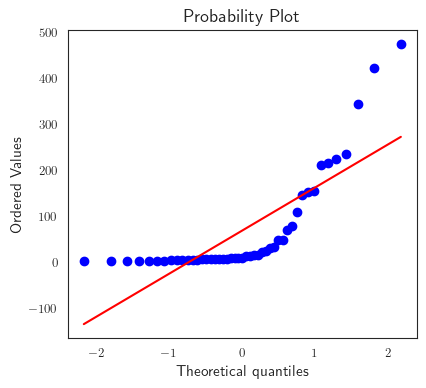

In [105]:

# Plot the data
fig, ax = plt.subplots()
stats.probplot(before_array, plot=ax)

# Test for normality
k2, p = stats.normaltest(before_array)
alpha = 0.05

if p < alpha:
    print("The data does not follow a normal distribution (p = {:.4f})".format(p))
else:
    print("The data follows a normal distribution (p = {:.4f})".format(p))

plt.show()


The data does not follow a normal distribution (p = 0.0000)


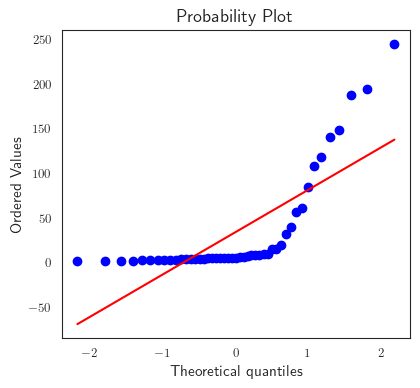

In [106]:

# Plot the data
fig, ax = plt.subplots()
stats.probplot(after_array, plot=ax)

# Test for normality
k2, p = stats.normaltest(after_array)
alpha = 0.05

if p < alpha:
    print("The data does not follow a normal distribution (p = {:.4f})".format(p))
else:
    print("The data follows a normal distribution (p = {:.4f})".format(p))

plt.show()


In [107]:
t, p = stats.wilcoxon(before_array, after_array)
t, p

/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


(149.0, 0.00015358049320888815)

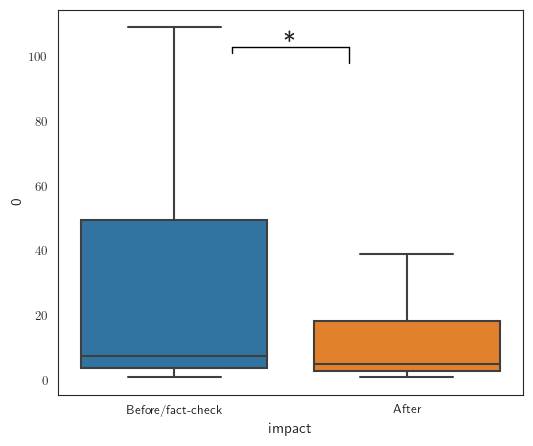

In [108]:
order = ['Before/fact-check', 'After']

sns.set_style("white")

fig, ax = plt.subplots(figsize=(6, 5))

sns.boxplot(impact, x='impact', y=0, order=order, showfliers=False)
# calculate the y position for the markers
ypos = ax.get_ylim()[1] * 0.9

# add significance markers
if p < 0.05:
    ax.plot([0.25, 0.75], [ypos, ypos], linewidth=1, color='black')
    ax.plot([0.25, 0.25], [ypos-2, ypos+0.05], linewidth=1, color='black')
    ax.plot([0.75, 0.75], [ypos-5, ypos+0.05], linewidth=1, color='black')
    ax.text(0.5, ypos, '*', ha='center', va='bottom', fontsize=20)


### Same without outliers

In [109]:
# Calculate the first and third quartiles (Q1 and Q3)
Q1 = before[0].quantile(0.25)
Q3 = before[0].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Calculate the inner and outer fences
inner_fence = Q1 - 1.5 * IQR
outer_fence = Q3 + 1.5 * IQR

# Identify the outliers
before_outliers = before[(before[0] < inner_fence) | (before[0] > outer_fence)]


# Calculate the first and third quartiles (Q1 and Q3)
Q1 = after[0].quantile(0.25)
Q3 = after[0].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Calculate the inner and outer fences
inner_fence = Q1 - 1.5 * IQR
outer_fence = Q3 + 1.5 * IQR

# Identify the outliers
after_outliers = after[(after[0] < inner_fence) | (after[0] > outer_fence)]

before_without_outliers = before[~before['fact_id'].isin(before_outliers['fact_id'])]
after_without_outliers = after[~after['fact_id'].isin(after_outliers['fact_id'])]
# Building the list to remove the outliers in both data
fact_both_wo_out = list(set(before_without_outliers['fact_id']).intersection(after_without_outliers['fact_id']))
before_array_wo_out = before_without_outliers[before_without_outliers['fact_id'].isin(fact_both_wo_out)][0]
after_array_wo_out = after_without_outliers[after_without_outliers['fact_id'].isin(fact_both_wo_out)][0]

The data does not follow a normal distribution (p = 0.0000)


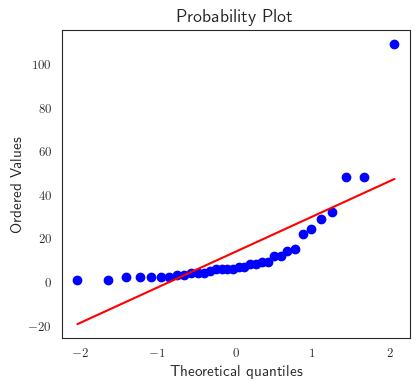

In [110]:

# Plot the data
fig, ax = plt.subplots()
stats.probplot(before_array_wo_out, plot=ax)

# Test for normality
k2, p = stats.normaltest(before_array_wo_out)
alpha = 0.05

if p < alpha:
    print("The data does not follow a normal distribution (p = {:.4f})".format(p))
else:
    print("The data follows a normal distribution (p = {:.4f})".format(p))

plt.show()

The data does not follow a normal distribution (p = 0.0000)


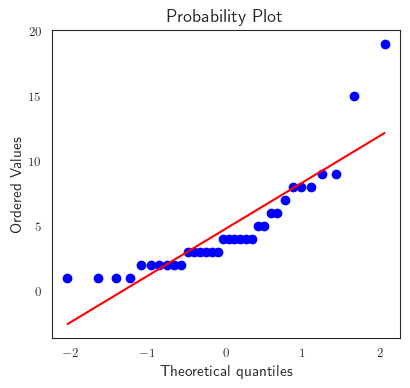

In [111]:
# Plot the data
fig, ax = plt.subplots()
stats.probplot(after_array_wo_out, plot=ax)

# Test for normality
k2, p = stats.normaltest(after_array_wo_out)
alpha = 0.05

if p < alpha:
    print("The data does not follow a normal distribution (p = {:.4f})".format(p))
else:
    print("The data follows a normal distribution (p = {:.4f})".format(p))

plt.show()


In [112]:
t_out, p_out = stats.wilcoxon(before_array_wo_out, after_array_wo_out)
t_out, p_out

/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:3337: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


(50.0, 0.0002833514157199189)

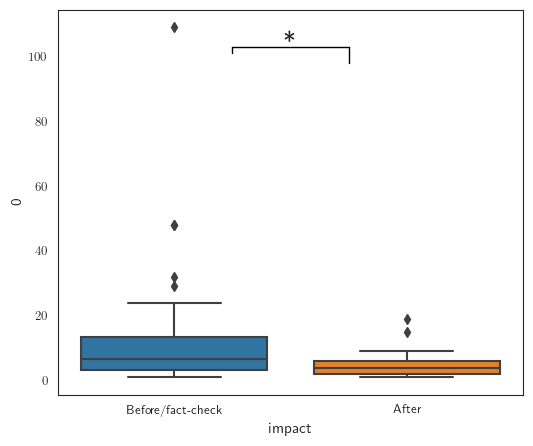

In [113]:
order = ['Before/fact-check', 'After']

sns.set_style("white")

fig, ax = plt.subplots(figsize=(6, 5))

sns.boxplot(impact[impact['fact_id'].isin(fact_both_wo_out)], x='impact', y=0, order=order, showfliers=True)
# calculate the y position for the markers
ypos = ax.get_ylim()[1] * 0.9

# add significance markers
if p < 0.05:
    ax.plot([0.25, 0.75], [ypos, ypos], linewidth=1, color='black')
    ax.plot([0.25, 0.25], [ypos-2, ypos+0.05], linewidth=1, color='black')
    ax.plot([0.75, 0.75], [ypos-5, ypos+0.05], linewidth=1, color='black')
    ax.text(0.5, ypos, '*', ha='center', va='bottom', fontsize=20)


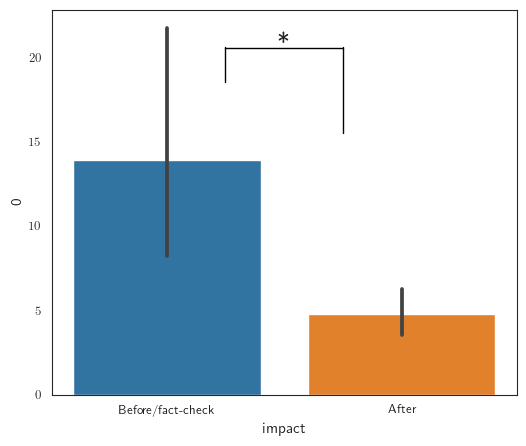

In [114]:
order = ['Before/fact-check', 'After']

sns.set_style("white")

fig, ax = plt.subplots(figsize=(6, 5))

sns.barplot(impact[impact['fact_id'].isin(fact_both_wo_out)], x='impact', y=0, order=order)
# calculate the y position for the markers
ypos = ax.get_ylim()[1] * 0.9

# add significance markers
if p_out < 0.05:
    ax.plot([0.25, 0.75], [ypos, ypos], linewidth=1, color='black')
    ax.plot([0.25, 0.25], [ypos-2, ypos+0.05], linewidth=1, color='black')
    ax.plot([0.75, 0.75], [ypos-5, ypos+0.05], linewidth=1, color='black')
    ax.text(0.5, ypos, '*', ha='center', va='bottom', fontsize=20)
